# Regression and Classification Notebook:
## Predict Remaining Useful Lifetime (RUL) of a NASA Run To Failure Dataset
<p style="margin:30px">
    <img style="display:inline" width=15% src="https://upload.wikimedia.org/wikipedia/commons/e/e5/NASA_logo.svg" alt="NASA" />
</p>

In this dataset different engines / turbofans (`engine_no`) are monitored over time. Time is given in cycles (`time_in_cycles`). After the last (=max) cycle of an engine maintenance is required.

The aim of this notebook is to predict the **Remaining Useful Life (RUL)** which can be defined as the amount of remaining cycles of an engine until maintenance is needed. Therefore different data are given for this time-series analysis:
- on the hand the `operational_settings` of each engine and
- on the other hand different sensor observations which are called `sensor_measurements` and recorded for each cycle.

The **dataset**, further information and some publications can be found in [NASA's Prognostics Center of Excellence](https://ti.arc.nasa.gov/tech/dash/groups/pcoe/prognostic-data-repository/#turbofan).


## Constants
- SUBWINDOW_LENGTH: Lenght of a subwindow = number of samples per subwindow
- SUBWINDOWS: Number of conherent subwindows per window

In [1]:
SUBWINDOW_LENGTH = 50
SUBWINDOWS = 50               # can be ignored if 'MAXIMIZE_SUBWINDOWS' is set on True
MAXIMIZE_SUBWINDOWS = True    # will create maximum number of subwindows out of a window

WINDOW_LENGTH = 100

#DEVICE = "cuda"
DEVICE = "cpu"


MAX_EPOCHS = 5

TARGET_CLIP_UPPER = False
TARGET_MAX = 125              # maximum RUL-value for each `unit_number`
TARGET_CLIP_LOWER = False
TARGET_MIN = 10               # minimum RUL-value for each `unit_number`

SUBWINDOW_TARGET = "min"      # Defines target within subwindow



## Import of predefined functions

If this Notebook runs on Google colab the installation of skorch might be neccessary

In [ ]:
onColab = False

# install skorch on colab notebooks if required
if onColab:
    ! [ ! -z "$COLAB_GPU" ] && pip install torch torchvision pillow==4.1.1 skorch

    from google.colab import drive
    import os

    drive.mount('/content/drive')
    os.chdir('/content/drive/MyDrive')


In [2]:
from datetime import datetime
import math
import numpy as np
from pathlib import Path
import pickle
import pandas as pd
import seaborn as sns
import scipy.stats as stats
import sys
import time
from tqdm import tqdm

import ipywidgets as widgets
from ipywidgets import interact

#from IPython.display import clear_output

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import torch
import torch.nn as nn
import torch.nn.functional as F

from sklearn.metrics import r2_score, make_scorer
from sklearn.model_selection import RandomizedSearchCV

import skorch
from skorch.regressor import NeuralNetRegressor
from skorch.helper import predefined_split
from skorch.callbacks import Callback, Checkpoint, LRScheduler



##  Custom function imports
E.g. functions to save figures, change colormap

In [3]:
from plotting_lib import return_current_date_and_time, truncate_colormap, save_figure,\
    plot_correlation_heatmap, plot_samples_over_feature, plot_all_features_for_all_units,\
        plot_percentage_of_removed_cycles, plot_colorbar, plot_samples_in_test_and_rul_dataset,\
            plot_mse_and_rul_scoring_function, plot_signal_contributions_of_pcs, plot_retained_variance,\
                plot_categories_over_pc_1_and_2


from data_preprocessing import subdivide_dataframe_by_feature, add_target_feature, create_coherent_windows,\
    get_subwindows_from_window, get_subwindows_from_dataframes, subdivide_indices_of_a_list,\
        normalize_feature_values, pipeline_level_0, pipeline_level_2

from regression_models import get_rul_score, HistoryPlotter, evaluate_regression_model, ConvRegressor,\
    DNNRegressor, RNNRegressor



## Import data from .txt-Files

In [4]:
FEATURES = ["operational_setting_%s" %i for i in range(1, 4)] +\
           ["sensor_measurement_%s" %i for i in range(1, 22)]

COLUMN_LABELS = ["unit_number", "time_in_cycles"] + FEATURES
SENSOR_FEATURES = COLUMN_LABELS[5:]

path_cands = [r"..\CMAPSSData",
              r".\CMAPSSData",
              r"CMAPSSData"]

path = [path for path in path_cands if Path(path).exists()][0]

INPUT_FILE_RUL = "RUL_FD001.txt"
INPUT_FILE_TRAIN = "train_FD001.txt"
INPUT_FILE_TEST = "test_FD001.txt"

'''
INPUT_FILE_RUL = "RUL_FD002.txt"
INPUT_FILE_TRAIN = "train_FD002.txt"
INPUT_FILE_TEST = "test_FD002.txt"
'''

INPUT_FILE_RUL = pd.read_csv(path + "/" + INPUT_FILE_RUL, header=None, names=["RUL_FD001"])
INPUT_FILE_RUL = INPUT_FILE_RUL["RUL_FD001"]

def from_csv(file):
    kwargs = dict(header=None, delim_whitespace=True, names=COLUMN_LABELS)
    data = pd.read_csv(file, **kwargs)
    return data

INPUT_FILE_TRAIN = from_csv(path + "/" + INPUT_FILE_TRAIN)
INPUT_FILE_TEST = from_csv(path + "/" + INPUT_FILE_TEST)



## Path to Modell-Checkpoints

In [5]:
Path("./logs").mkdir(parents=True, exist_ok=True)
CHECKPOINT = Checkpoint(dirname="./logs/" + time.strftime("%Y%m%d-%H%M%S"), f_pickle="model.pkl")



---
---
# **START OF DATA PREPROCESSING AND DESCRIPTIVE STATISTICS**
---
---

The following cells present multiple functions and their arguments for data preprocessing.
Finally, the whole data preprocessing workflow can be executed by the functions `pipeline_level_0` or `pipeline_level_2`

### Ratio of withholded Remaining Useful Lifetime to last time cycle in test dataset
In contrast to the training dataset (`INPUT_FILE_TRAIN`) the last (= max) cycle in the test dataset (`INPUT_FILE_TEST`)  is not equal to the cycle when maintenance is required.

To get this final cycle it is necessary to add the information given in `INPUT_FILE_RUL` to the test dataset's `time_in_cycles`.

*(For participants of a challenge the information given in `INPUT_FILE_RUL` was withholded.)*

Figure not saved


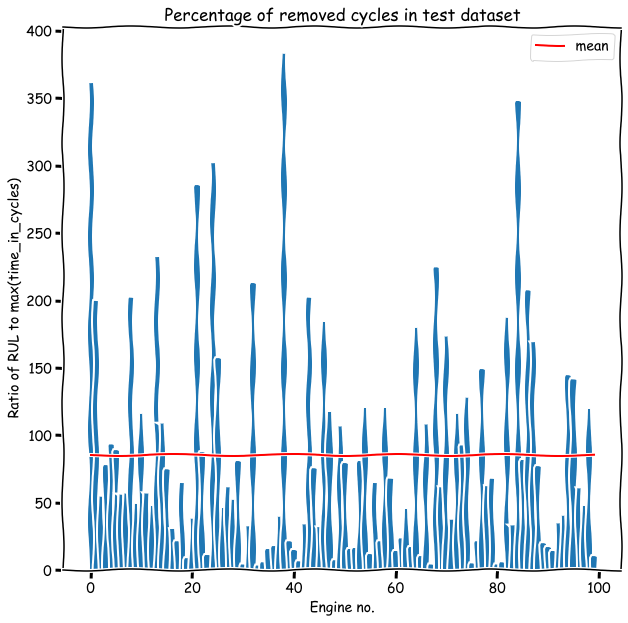

In [6]:
plot_percentage_of_removed_cycles(input_file_rul=INPUT_FILE_RUL,
                                  input_file_test=INPUT_FILE_TEST)

#### Plot cycles in dataset `INPUT_FILE_RUL` together with cycles in dataset `INPUT_FILE_TEST`

Figure not saved


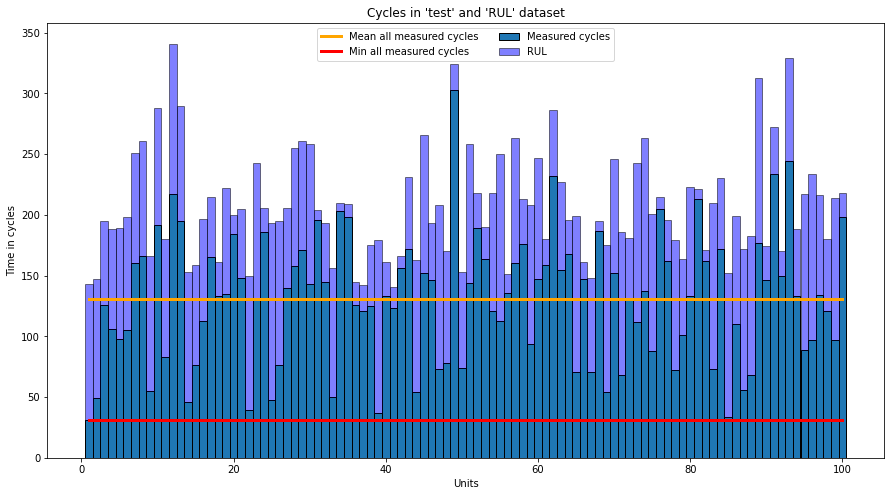

In [7]:
plot_samples_in_test_and_rul_dataset(input_file_test=INPUT_FILE_TEST,
                                     input_file_rul=INPUT_FILE_RUL)

### Print parts of data structure (dataframes)
print(INPUT_FILE_RUL.head())
print(INPUT_FILE_TRAIN.head())
print(INPUT_FILE_TEST.head())
print(len(INPUT_FILE_TRAIN.columns))
print(len(INPUT_FILE_TEST.columns))

print(len(INPUT_FILE_RUL))
print(len(INPUT_FILE_TRAIN))
print(len(INPUT_FILE_TEST))
print(INPUT_FILE_TRAIN.unit_number.value_counts().sort_index())
print(INPUT_FILE_TEST.unit_number.value_counts().sort_index())

for _, data in INPUT_FILE_TRAIN.groupby("unit_number"):
    print("Cycles for first unit in training:\n", data["time_in_cycles"].sort_values().values, "\n")
    break

for _, data in INPUT_FILE_TEST.groupby("unit_number"):
    print("Cycles for first unit in test:\n", data["time_in_cycles"].sort_values().values, "\n")
    break


### Plot correlation heatmap

Figure not saved


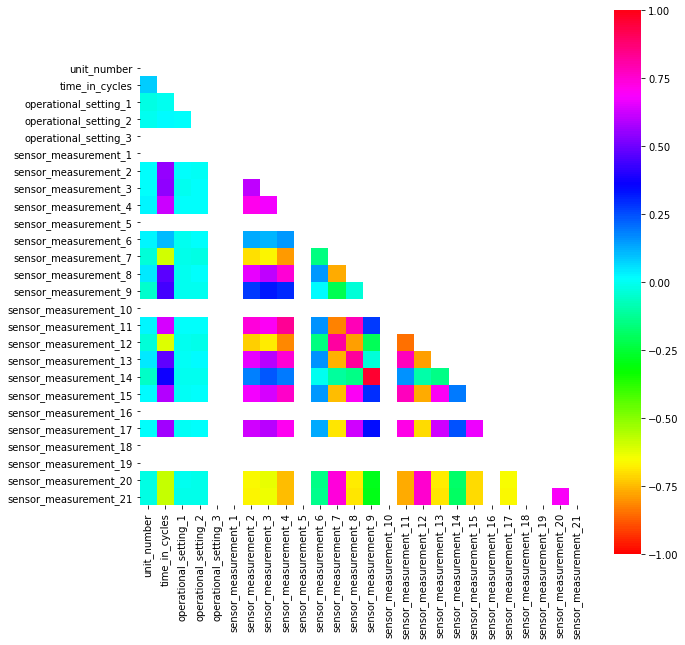

In [8]:
plot_correlation_heatmap(input_file=INPUT_FILE_TRAIN)

## Define RUL Score
The RUL ('Remaning Useful Lifetime') Score is an indicator function which measures the performance of an RUL estimation. It is used in RUL estimation related [publications](https://www.researchgate.net/publication/330254823_Remaining_Useful_Life_Estimation_in_Prognostics_Using_Deep_Bidirectional_LSTM_Neural_Network) and PHM Competitions.
The definition of the scoring function is as follows: <br>

\begin{equation}
  D_{it} =
    \begin{cases}
      \sum_{i=1}^n  \exp(-\frac{h_i}{13}) - 1 &, h_i < 0 \\
      \sum_{i=1}^n \exp(-\frac{h_i}{10}) -1 &, h_i \ge 0 \\
    \end{cases}       
\end{equation} <br>
\begin{align}
      \text{with } h_i = \mathit{RUL}_{pred, i} - \mathit{RUL}_{gt, i}
\end{align}


Herein $RUL_{pred, i}$ stands for the remaining useful lifetime predicted with the regression model for an evaluated sample *$i$* out of *$n$* samples.

$RUL_{gt, i}$ is the underlying ground truth.


As shown in the following figure, the RUL-score adds weight especially to differences *$h_i \geq 0$* in contrast to the linear mean squared error function $$MSE = \frac{1}{n} \cdot \sum_{i}^{n} h_i^2$$

Figure not saved


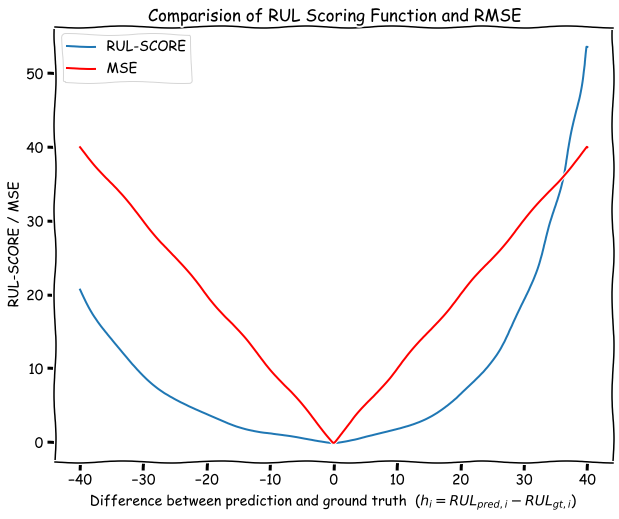

In [9]:
plot_mse_and_rul_scoring_function()

## Create list of dataframes

In [10]:
list_of_dataframes = subdivide_dataframe_by_feature(INPUT_FILE_TRAIN)
print(len(list_of_dataframes))

100


### Validate function 'subdivide_dataset_by_feature':
- Is subdivision according to unit-number implemented correctly?

In [11]:
feature = "unit_number"

list_of_dataframes = subdivide_dataframe_by_feature(INPUT_FILE_TRAIN,
                                                    feature)

train_data_units = INPUT_FILE_TRAIN[feature].unique()
for list_index, unit in enumerate(train_data_units):
    assert (INPUT_FILE_TRAIN[INPUT_FILE_TRAIN[feature] == unit] == list_of_dataframes[list_index]).all().all()

## Define target values for regression for list of dataframes
- Add 'target'-feature to a single dataframe (entry from 'list_of_dataframes')
- Target feature can be:
    - RUL ("Remaining useful lifetime" = Timedelta): Last timestamp minus current timestamp
    - Remaining cycles: last cycle minuns current cycle

### Validate function 'add_target_feature' for list of dataframes

In [12]:
list_of_dataframes = subdivide_dataframe_by_feature(INPUT_FILE_TRAIN)

for dataframe in list_of_dataframes:
    add_target_feature(dataframe,
                       target_clip_upper=TARGET_CLIP_UPPER)


selected_df = list_of_dataframes[0]
# assert (selected_df.time_in_cycles.iloc[-1] - selected_df.time_in_cycles.iloc[0]) == selected_df.target.iloc[0]

selected_df.head()

unit_number  time_in_cycles  operational_setting_1  operational_setting_2  \
0            1               1                -0.0007                -0.0004   
1            1               2                 0.0019                -0.0003   
2            1               3                -0.0043                 0.0003   
3            1               4                 0.0007                 0.0000   
4            1               5                -0.0019                -0.0002   

   operational_setting_3  sensor_measurement_1  sensor_measurement_2  \
0                  100.0                518.67                641.82   
1                  100.0                518.67                642.15   
2                  100.0                518.67                642.35   
3                  100.0                518.67                642.35   
4                  100.0                518.67                642.37   

   sensor_measurement_3  sensor_measurement_4  sensor_measurement_5  ...  \
0               1589.70               1400.60                 14.62  ...   
1               1591.82               1403.14                 14.62  ...   
2               1587.99               1404.20                 14.62  ...   
3               1582.79               1401.87                 14.62  ...   
4               1582.85               1406.22                 14.62  ...   

   sensor_measurement_13  sensor_measurement_14  sensor_measurement_15  \
0                2388.02                8138.62                 8.4195   
1                2388.07                8131.49                 8.4318   
2                2388.03                8133.23                 8.4178   
3                2388.08                8133.83                 8.3682   
4                2388.04                8133.80                 8.4294   

   sensor_measurement_16  sensor_measurement_17  sensor_measurement_18  \
0                   0.03                    392                   2388   
1                   0.03                    392                   2388   
2                   0.03                    390                   2388   
3                   0.03                    392                   2388   
4                   0.03                    393                   2388   

   sensor_measurement_19  sensor_measurement_20  sensor_measurement_21  target  
0                  100.0                  39.06                23.4190   191.0  
1                  100.0                  39.00                23.4236   190.0  
2                  100.0                  38.95                23.3442   189.0  
3                  100.0                  38.88                23.3739   188.0  
4                  100.0                  38.90                23.4044   187.0  

[5 rows x 27 columns]

### Validate function 'add_target_feature' for timeseries (pd.Timestamps)

In [13]:
test_df = pd.date_range(start="1/1/2018", periods=10, freq="1 h")
test_df = pd.DataFrame(test_df, columns=["Time"])


add_target_feature(test_df,
                   regression_feature="Time")

test_df

Time  target
0 2018-01-01 00:00:00     9.0
1 2018-01-01 01:00:00     8.0
2 2018-01-01 02:00:00     7.0
3 2018-01-01 03:00:00     6.0
4 2018-01-01 04:00:00     5.0
5 2018-01-01 05:00:00     4.0
6 2018-01-01 06:00:00     3.0
7 2018-01-01 07:00:00     2.0
8 2018-01-01 08:00:00     1.0
9 2018-01-01 09:00:00     0.0

## Plot histogram: number of samples per `unit_number`

Figure not saved


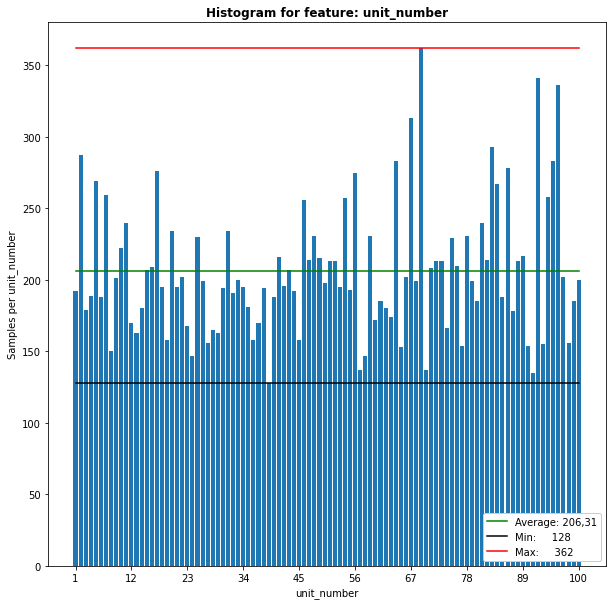

In [14]:
plot_samples_over_feature(INPUT_FILE_TRAIN,
                          feature="unit_number",
                          saving_path=r".\Plots",
                          save_fig=False,
                          plot_format="pdf")

## Plot all features over time for a specific unit / for all units

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:19<00:00,  5.17it/s]


Figure not saved


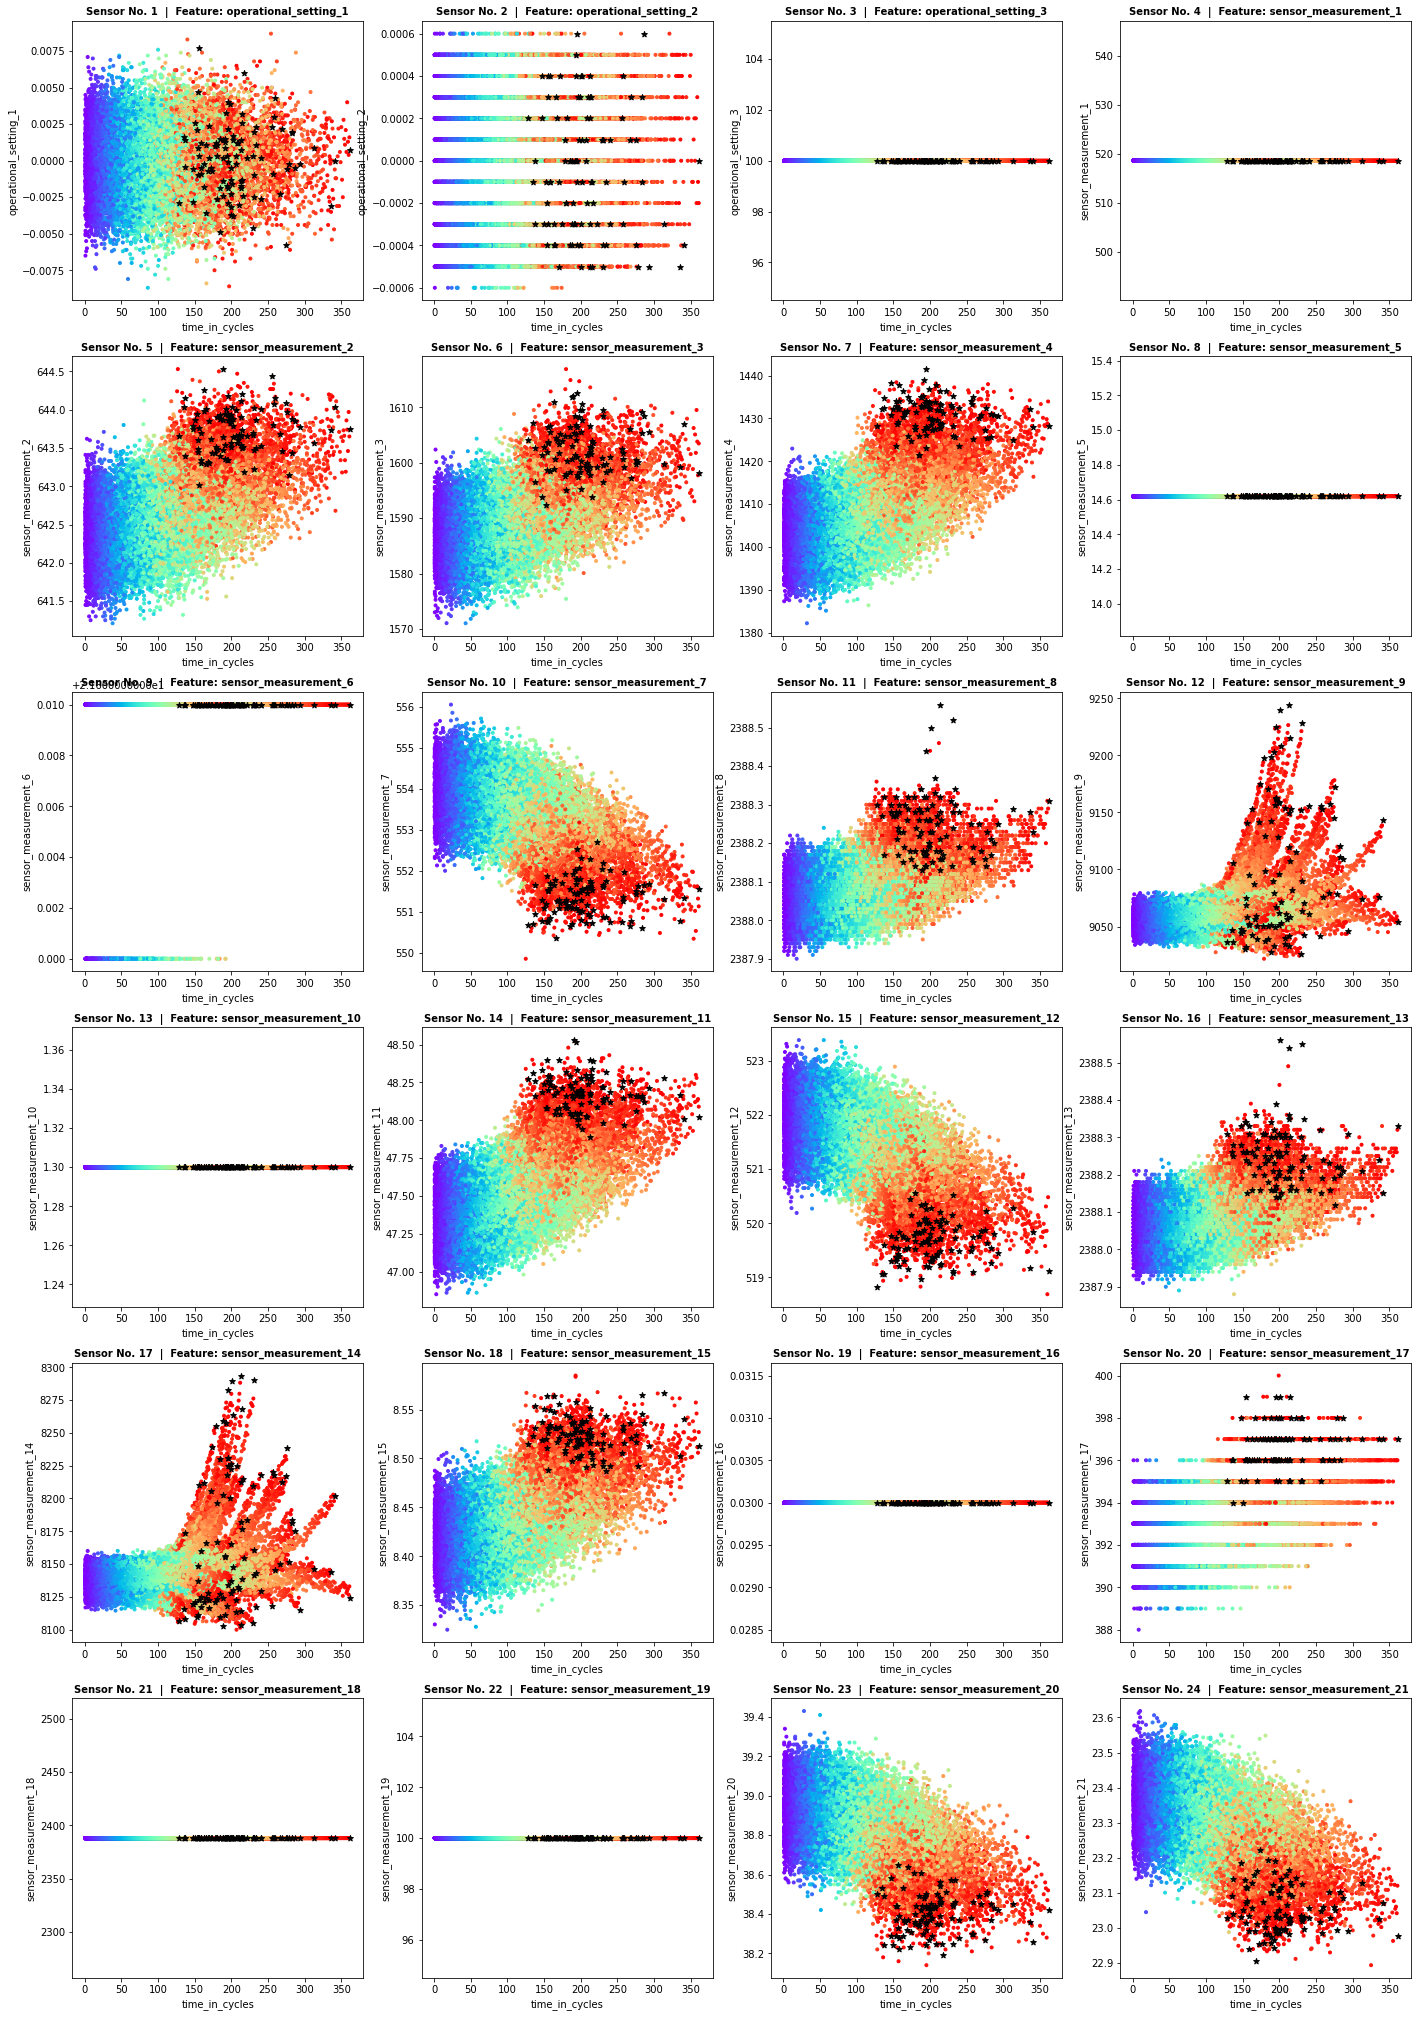

In [15]:
plot_all_features_for_all_units(list_of_dataframes,
                                features=FEATURES,
                                colormap_feature="time_in_cycles",
                                number_of_columns=4,
                                saving_path=r".\Plots",
                                save_fig=False,
                                plot_format="png")

### Plot colorbar to explain colormap in plot above

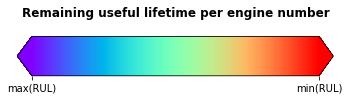

In [16]:
cmap = plt.cm.rainbow
cmap_ticks = [0, 1]
cmap_ticklabels = ["max(RUL)", "min(RUL)"]
title = "Remaining useful lifetime per engine number"


plot_colorbar(cmap=cmap,
              cmap_ticks=cmap_ticks,
              cmap_ticklabels=cmap_ticklabels,
              figure_size=(5, 1.5),
              title=title,
              saving_path=r".\Plots",
              save_fig=True,
              plot_format="pdf")

## Create coherent windows per dataframe
- Result is a list of dataframes made out of a single dataframe
- list entries are so called 'windows'. A window is a coherent subset of a dataset without interruptions, for example due to interruptions during measurements.
- The data within a window (subset) can be regarded as complete
- A window must have a minimum sample size (argument 'min_window')
- $\color{green}{\text{Since all windows are coherent into this dataset, creating windows is optional -> Only one window per dataframe (subset).}}$


### Validate function 'create_coherent_windows'
- Therefore manipulate coherent dataset only for test purpose

In [17]:
test_df = list_of_dataframes[0]
test_df_indices = test_df.index

np.random.seed(42)
used_indices = np.random.choice(test_df_indices,
                                size=int(0.8 * len(test_df)),
                                replace=False)
used_indices.sort()
#print(used_indices)
#print("Used indices [%]:\t", round(100 * len(used_indices) / len(test_df_indices), 2))

unused_indices = np.setdiff1d(test_df_indices, used_indices)
print("Unused loc-indices (%s):\n" % len(unused_indices), unused_indices)

test_df_reduced = test_df.iloc[used_indices]
window_list = create_coherent_windows(test_df_reduced,
                                      min_window=10,
                                      print_output=True)

Unused loc-indices (39):
 [  1  14  20  21  37  48  50  52  54  57  58  63  71  74  87  88  92  99
 102 103 106 107 116 121 129 130 134 149 151 157 160 167 168 176 179 181
 185 188 191]

Start (iloc):	 0 	End (iloc) - exclusive:	 1 	Width:	 1
Start (loc):	 0 	End (loc) - inclusive:	 0
Window can't be used due to window lenght

Start (iloc):	 1 	End (iloc) - exclusive:	 13 	Width:	 12
Start (loc):	 2 	End (loc) - inclusive:	 13

Start (iloc):	 13 	End (iloc) - exclusive:	 18 	Width:	 5
Start (loc):	 15 	End (loc) - inclusive:	 19
Window can't be used due to window lenght

Start (iloc):	 18 	End (iloc) - exclusive:	 33 	Width:	 15
Start (loc):	 22 	End (loc) - inclusive:	 36

Start (iloc):	 33 	End (iloc) - exclusive:	 43 	Width:	 10
Start (loc):	 38 	End (loc) - inclusive:	 47

Start (iloc):	 43 	End (iloc) - exclusive:	 44 	Width:	 1
Start (loc):	 49 	End (loc) - inclusive:	 49
Window can't be used due to window lenght

Start (iloc):	 44 	End (iloc) - exclusive:	 45 	Width:	 1
Start (l

In [18]:
test_df = list_of_dataframes[0]
window_list = create_coherent_windows(test_df,
                                      min_window=200,
                                      print_output=True)
print(len(test_df))
if window_list != None:
    print(len(window_list))
else: 
    print(window_list)

There's no gap between single measurements and splitting in windows is not necessary

DataFrame can't be used
192
None


## Create subwindows from windows
- Arguments for 'subwindow_target':
    - 'min': take minimum of target-series in subwindow as target value for whole subwindow
    - 'max': take maximum of target-series in subwindow as target value for whole subwindow
    - 'mean': take mean of target-series in subwindow as target value for whole subwindow

#### $\color{green}{\text{Done:}}$
- Check that there are no duplicates in subwindows in case 'maximize_subwindows=False' and sort indices correctly, so that shuffle makes sense?
 -> Workaround: New implementation for 'start_index'

### Validate function 'get_subwindows_from_window'
- Also test of stacking multiple subwindows created from multiple windows

In [19]:
# Create list of dataframes
list_of_dataframes = subdivide_dataframe_by_feature(INPUT_FILE_TRAIN)

# Add target values to each dataframe
for dataframe in list_of_dataframes:
    add_target_feature(dataframe,
                       target_clip_upper=TARGET_CLIP_UPPER,
                       target_max=TARGET_MAX)

test_df = list_of_dataframes[0]
test_window_list = create_coherent_windows(test_df)
test_window_df = test_window_list[0]

feature_values_per_window_1, target_values_per_window_1 = get_subwindows_from_window(test_window_df,
                                                                                     features=FEATURES,
                                                                                     subwindow_target="min",
                                                                                     maximize_subwindows=True,
                                                                                     shuffle=False)

feature_values_per_window_2, target_values_per_window_2 = get_subwindows_from_window(test_window_df,
                                                                                     features=FEATURES,
                                                                                     subwindow_target="mean",
                                                                                     shuffle=False)

print("Samples in window_df:\t\t\t", len(test_window_df), "\n")
print("Shape 'feature_values_per_window_1':\t", feature_values_per_window_1.shape)
print("Shape 'target_values_per_window_1':\t", target_values_per_window_1.shape)

print("Shape 'feature_values_per_window_2':\t", feature_values_per_window_2.shape)
print("Shape 'target_values_per_window_2':\t", target_values_per_window_2.shape)
print("\n")
#print("\n", target_values_per_window_1)
#print("\n", target_values_per_window_2)

# Test stacking / concatenating
all_feature_values = np.vstack([feature_values_per_window_1, feature_values_per_window_2])
all_target_values = np.vstack([target_values_per_window_1, target_values_per_window_2])
print("Shape 'all_feature_values':\t\t", all_feature_values.shape)
print("Shape 'all_target_values':\t\t", all_target_values.shape)

assert target_values_per_window_2[0] == all_target_values[target_values_per_window_1.shape[0]]


# Try reproducing "unit_number" for each subwindow
feature_values_per_window_2, engine_number = get_subwindows_from_window(test_window_df,
                                                                        features=FEATURES,
                                                                        target_feature="unit_number",
                                                                        shuffle=False)

engine_number = np.concatenate(engine_number).astype(int)
print(engine_number)

Samples in window_df:			 192 

Shape 'feature_values_per_window_1':	 (142, 24, 50)
Shape 'target_values_per_window_1':	 (142, 1)
Shape 'feature_values_per_window_2':	 (32, 24, 50)
Shape 'target_values_per_window_2':	 (32, 1)


Shape 'all_feature_values':		 (174, 24, 50)
Shape 'all_target_values':		 (174, 1)
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


## Split into train-, test-, validation subset

Definition of a function for the subdivision of the whole dataset to a training, a validation and a test subset. 
The training dataset's purpose is to train the model. The validation dataset is used for the best selection of a model out of all training iterations, whereas the test dataset won't be used during the training process. Its purpose is to finally evaluate the best model.  
All subsets don't have a common intersection. This means that a single measurement can only be found once in one of the subsets.

#### Used functions:
- https://numpy.org/doc/stable/reference/generated/numpy.setdiff1d.html
- https://pandas.pydata.org/docs/reference/api/pandas.Series.isin.html


#### Different possibilities for subdivision:
- Split list_of_dataframes completely: a specific unit will only be used in the training, validation OR test subset
- Split after creating all subwindows from each dataframe (subset): subwindows of a specific unit can be found in training, validation AND test subset


- Level 0: Separate whole dataframes from others and for no other subset
- Level 1: Separate whole windows (out of dataframes) from other windows; windows of all dataframes could be found in all subsets; $\color{red}{\text{Not implemented yet, since windows are coherent in this dataset}}$
- Level 2: Separate subwindows; subwindows of all dataframes could be found in all subsets

### Function for Level 0 and Level 2:

#### Validate function 'get_subwindows_from_dataframes'

In [20]:
# Create list of dataframes
list_of_dataframes = subdivide_dataframe_by_feature(INPUT_FILE_TRAIN)

# Add target values to each dataframe
for dataframe in list_of_dataframes:
    add_target_feature(dataframe,
                       target_clip_upper=TARGET_CLIP_UPPER,
                       target_max=TARGET_MAX)


all_time_in_cycles, all_target_values = get_subwindows_from_dataframes(list_of_dataframes,
                                                                       features=["time_in_cycles"],
                                                                       subwindow_length=SUBWINDOW_LENGTH,
                                                                       maximize_subwindows=True)
all_time_in_cycles = np.concatenate(all_time_in_cycles).astype(int)


all_feature_values, all_unit_numbers = get_subwindows_from_dataframes(list_of_dataframes,
                                                                      features=FEATURES,
                                                                      target_feature="unit_number",
                                                                      subwindow_length=SUBWINDOW_LENGTH,
                                                                      maximize_subwindows=True)

all_unit_numbers = all_unit_numbers.astype(int)

print("Number of dataframes:\t\t", len(list_of_dataframes))
print("Shape 'all_feature_values':\t", all_feature_values.shape)
print("Shape 'all_time_in_cycles':\t", all_time_in_cycles.shape)
print("Shape 'all_target_values':\t", all_target_values.shape)
print("Shape 'all_unit_numbers':\t", all_unit_numbers.shape)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:14<00:00,  7.03it/s]

Number of dataframes:		 100
Shape 'all_feature_values':	 (15631, 24, 50)
Shape 'all_time_in_cycles':	 (15631, 50)
Shape 'all_target_values':	 (15631, 1)
Shape 'all_unit_numbers':	 (15631, 1)


### Level 0: Function to separate whole dataframes from others

#### Validate function 'subdivide_indices_of_a_list'

In [21]:
# Create list of dataframes
list_of_dataframes = subdivide_dataframe_by_feature(INPUT_FILE_TRAIN)

# Add target values to each dataframe
for dataframe in list_of_dataframes:
    add_target_feature(dataframe)

list_indices = list(range(len(list_of_dataframes)))
first_list_indices, second_list_indices = subdivide_indices_of_a_list(list_indices,
                                                                      fixed_seed=True,
                                                                      sort_lists=True)

print("'first_list_indices':                     ", first_list_indices)
print("'second_list_indices' (before splitting): ", second_list_indices)


second_list_indices, third_list_indices = subdivide_indices_of_a_list(second_list_indices,
                                                                      first_list_proportion=0.5,
                                                                      fixed_seed=True,
                                                                      sort_lists=True)

print("'second_list_indices' (after splitting):  ", second_list_indices)
print("'third_list_indices':                     ", third_list_indices)


'first_list_indices':                      [ 0  3  4  5  6  7  8  9 10 11 12 13 15 16 17 18 19 22 24 25 26 27 28 30
 31 33 34 35 36 38 39 40 42 43 44 45 46 47 49 50 53 54 55 56 61 62 64 65
 66 67 68 69 70 72 73 76 77 78 80 81 83 85 88 89 90 93 95 96 97 99]
'second_list_indices' (before splitting):  [ 1  2 14 20 21 23 29 32 37 41 48 51 52 57 58 59 60 63 71 74 75 79 82 84
 86 87 91 92 94 98]
'second_list_indices' (after splitting):   [ 1 21 23 37 41 51 52 57 59 60 63 84 86 92 94]
'third_list_indices':                      [ 2 14 20 29 32 48 58 71 74 75 79 82 87 91 98]


## Split according to Level 0: Separate whole dataframes from others

In [22]:
X_train, y_train = get_subwindows_from_dataframes([list_of_dataframes[i] for i in first_list_indices],
                                                  features=FEATURES)
X_test, y_test = get_subwindows_from_dataframes([list_of_dataframes[j] for j in second_list_indices],
                                                features=FEATURES)
X_val, y_val = get_subwindows_from_dataframes([list_of_dataframes[k] for k in third_list_indices],
                                              features=FEATURES)

print("Number of dataframes:\t", len(list_of_dataframes))
print("Shape 'X_train':\t", X_train.shape)
print("Shape 'X_test':\t\t", X_test.shape)
print("Shape 'X_val':\t\t", X_val.shape)

100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 33.27it/s]

Number of dataframes:	 100
Shape 'X_train':	 (2240, 24, 50)
Shape 'X_test':		 (480, 24, 50)
Shape 'X_val':		 (480, 24, 50)


#### If additional information about subwindows is required

In [23]:
# Training dataset
time_in_cycles_train, y_train = get_subwindows_from_dataframes([list_of_dataframes[i] for i in first_list_indices],
                                                               features=["time_in_cycles"])

time_in_cycles_train = np.concatenate(time_in_cycles_train).astype(int)


X_train, unit_train = get_subwindows_from_dataframes([list_of_dataframes[i] for i in first_list_indices],
                                                     features=FEATURES,
                                                     target_feature="unit_number")

unit_train = unit_train.astype(int)

print("Shape 'X_train':\t\t", X_train.shape)
print("Shape 'time_in_cycles_train':\t", time_in_cycles_train.shape)
print("Shape 'y_train':\t\t", y_train.shape)
print("Shape 'unit_train':\t\t", unit_train.shape)


# Test dataset
time_in_cycles_test, y_test = get_subwindows_from_dataframes([list_of_dataframes[i] for i in second_list_indices],
                                                             features=["time_in_cycles"])

time_in_cycles_test = np.concatenate(time_in_cycles_test).astype(int)


X_test, unit_test = get_subwindows_from_dataframes([list_of_dataframes[i] for i in second_list_indices],
                                                   features=FEATURES,
                                                   target_feature="unit_number")

unit_test = unit_test.astype(int)

print("Shape 'X_test':\t\t\t", X_test.shape)
print("Shape 'time_in_cycles_test':\t", time_in_cycles_test.shape)
print("Shape 'y_test':\t\t\t", y_test.shape)
print("Shape 'unit_test':\t\t", unit_test.shape)


# Validation dataset
time_in_cycles_val, y_val = get_subwindows_from_dataframes([list_of_dataframes[i] for i in third_list_indices],
                                                           features=["time_in_cycles"])

time_in_cycles_val = np.concatenate(time_in_cycles_val).astype(int)


X_val, unit_val = get_subwindows_from_dataframes([list_of_dataframes[i] for i in third_list_indices],
                                                 features=FEATURES,
                                                 target_feature="unit_number")

unit_val = unit_val.astype(int)

print("Shape 'X_val':\t\t\t", X_val.shape)
print("Shape 'time_in_cycles_val':\t", time_in_cycles_val.shape)
print("Shape 'unit_val':\t\t", unit_val.shape)
print("Shape 'y_val':\t\t\t", y_val.shape)

 27%|██████████████████████▏                                                            | 4/15 [00:00<00:00, 34.28it/s]

Shape 'X_train':		 (2240, 24, 50)
Shape 'time_in_cycles_train':	 (2240, 50)
Shape 'y_train':		 (2240, 1)
Shape 'unit_train':		 (2240, 1)


 27%|██████████████████████▏                                                            | 4/15 [00:00<00:00, 32.82it/s]

Shape 'X_test':			 (480, 24, 50)
Shape 'time_in_cycles_test':	 (480, 50)
Shape 'y_test':			 (480, 1)
Shape 'unit_test':		 (480, 1)


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 22.68it/s]

Shape 'X_val':			 (480, 24, 50)
Shape 'time_in_cycles_val':	 (480, 50)
Shape 'unit_val':		 (480, 1)
Shape 'y_val':			 (480, 1)


### Level 2: Stack all subwindows created out of all windows for all dataframes (subsets) for a whole dataset

In [24]:
np.random.seed(42)

# Create list of dataframes
list_of_dataframes = subdivide_dataframe_by_feature(INPUT_FILE_TRAIN)

# Add target values to each dataframe
for dataframe in list_of_dataframes:
    add_target_feature(dataframe)

all_time_in_cycles, all_target_values = get_subwindows_from_dataframes(list_of_dataframes,
                                                                       features=["time_in_cycles"],
                                                                       subwindow_length=SUBWINDOW_LENGTH,
                                                                       subwindow_target="min",
                                                                       subwindows=40)

all_time_in_cycles = np.concatenate(all_time_in_cycles).astype(int)


all_feature_values, all_unit_numbers = get_subwindows_from_dataframes(list_of_dataframes,
                                                                      features=FEATURES,
                                                                      target_feature="unit_number",
                                                                      subwindow_length=SUBWINDOW_LENGTH,
                                                                      subwindow_target="min",
                                                                      subwindows=40)

all_unit_numbers = all_unit_numbers.astype(int)

print("Number of dataframes:          ", len(list_of_dataframes))
print("Shape 'all_feature_values':    ", all_feature_values.shape)
print("Shape 'all_time_in_cycles':    ", all_unit_numbers.shape)
print("Shape 'all_unit_numbers':      ", all_unit_numbers.shape)
print("Shape 'all_unit_numbers':      ", all_target_values.shape)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 27.11it/s]

Number of dataframes:           100
Shape 'all_feature_values':     (4000, 24, 50)
Shape 'all_time_in_cycles':     (4000, 1)
Shape 'all_unit_numbers':       (4000, 1)
Shape 'all_unit_numbers':       (4000, 1)


### Reduce features to raise assertion-error in normalization

FEATURES_RED = ["unit_number", "time_in_cycles"] + [FEATURES[i] for i in [2, 3, 7, 12, 18, 20, 21]]
FEATURED_DROP = [i for i in FEATURES if i not in FEATURES_RED]

#### Create list of dataframes
list_of_dataframes = subdivide_dataframe_by_feature(INPUT_FILE_TRAIN)

for index in range(len(list_of_dataframes)):
    list_of_dataframes[index] = list_of_dataframes[index].drop(FEATURED_DROP, axis=1)

#### Add target values to each dataframe
for dataframe in list_of_dataframes:
    add_target_feature(dataframe)


all_feature_values, all_target_values = get_subwindows_from_dataframes(list_of_dataframes,
                                                                       subwindows=40,
                                                                       features=FEATURES_RED[2:])

print("Number of dataframes:\t\t", len(list_of_dataframes))
print("Shape 'all_feature_values':\t", all_feature_values.shape)

## Split according to Level 2: Separate subwindows; subwindows of all dataframes could be found in all subsets

In [25]:
list_indices = list(range(all_feature_values.shape[0]))

first_list_indices, second_list_indices = subdivide_indices_of_a_list(list_indices,
                                                                      first_list_proportion=0.5,
                                                                      fixed_seed=True,
                                                                      sort_lists=True)

second_list_indices, third_list_indices = subdivide_indices_of_a_list(second_list_indices,
                                                                      first_list_proportion=0.5,
                                                                      fixed_seed=True,
                                                                      sort_lists=True)

X_train, y_train = all_feature_values[first_list_indices], all_target_values[first_list_indices]
X_test, y_test = all_feature_values[second_list_indices], all_target_values[second_list_indices]
X_val, y_val = all_feature_values[third_list_indices], all_target_values[third_list_indices]

time_in_cycles_train, unit_train = all_time_in_cycles[first_list_indices], all_unit_numbers[first_list_indices]
time_in_cycles_test, unit_test = all_time_in_cycles[second_list_indices], all_unit_numbers[second_list_indices]
time_in_cycles_val, unit_val = all_time_in_cycles[third_list_indices], all_unit_numbers[third_list_indices]


print("Number of dataframes:         ", len(list_of_dataframes))
print("Shape 'X_train':              ", X_train.shape)
print("Shape 'y_train':              ", y_train.shape)
print("Shape 'time_in_cycles_train': ", time_in_cycles_train.shape)
print("Shape 'unit_train':           ", unit_train.shape, end="\n\n")

print("Shape 'X_test':               ", X_test.shape)
print("Shape 'y_test':               ", y_test.shape)
print("Shape 'time_in_cycles_test':  ", time_in_cycles_test.shape)
print("Shape 'unit_test':            ", unit_test.shape, end="\n\n")

print("Shape 'X_val':                ", X_val.shape)
print("Shape 'y_val':\               ", y_val.shape)
print("Shape 'time_in_cycles_val':   ", time_in_cycles_val.shape)
print("Shape 'unit_val':             ", unit_val.shape, end="\n\n")



Number of dataframes:          100
Shape 'X_train':               (2000, 24, 50)
Shape 'y_train':               (2000, 1)
Shape 'time_in_cycles_train':  (2000, 50)
Shape 'unit_train':            (2000, 1)

Shape 'X_test':                (1000, 24, 50)
Shape 'y_test':                (1000, 1)
Shape 'time_in_cycles_test':   (1000, 50)
Shape 'unit_test':             (1000, 1)

Shape 'X_val':                 (1000, 24, 50)
Shape 'y_val':\                (1000, 1)
Shape 'time_in_cycles_val':    (1000, 50)
Shape 'unit_val':              (1000, 1)



## Normalize features


### Execute function 'normalize_features'

In [26]:
X_train_norm, standardization_params = normalize_feature_values(features_array=X_train)

X_test_norm, _ = normalize_feature_values(features_array=X_test,
                                          train_standardization_params=standardization_params)

X_val_norm, _ = normalize_feature_values(features_array=X_val,
                                         train_standardization_params=standardization_params)

print("Shape 'X_train' before normalization:\t", X_train.shape)
print("Shape 'X_train' after normalization:\t", X_train_norm.shape)
print("Shape 'y_train':\t\t\t", y_train.shape)
print("\n")
print("Shape 'X_test' before normalization:\t", X_test.shape)
print("Shape 'X_test_norm' after normalization:", X_test_norm.shape)
print("Shape 'y_test':\t\t\t\t", y_test.shape)
print("\n")
print("Shape 'X_val' before normalization:\t", X_val.shape)
print("Shape 'X_val_norm' after normalization:\t", X_val_norm.shape)
print("Shape 'y_val':\t\t\t\t", y_val.shape)



Len invalid features:	 7
Invalid features are:	 [2, 3, 7, 12, 18, 20, 21] 

Len invalid features:	 7
Invalid features are:	 [2, 3, 7, 12, 18, 20, 21] 

Len invalid features:	 7
Invalid features are:	 [2, 3, 7, 12, 18, 20, 21] 

Shape 'X_train' before normalization:	 (2000, 24, 50)
Shape 'X_train' after normalization:	 (2000, 17, 50)
Shape 'y_train':			 (2000, 1)


Shape 'X_test' before normalization:	 (1000, 24, 50)
Shape 'X_test_norm' after normalization: (1000, 17, 50)
Shape 'y_test':				 (1000, 1)


Shape 'X_val' before normalization:	 (1000, 24, 50)
Shape 'X_val_norm' after normalization:	 (1000, 17, 50)
Shape 'y_val':				 (1000, 1)


## $\color{green}{\text{Complete Pipeline according to level 0}}$
**Level 0**: Separate whole dataframes from others. Subwidows for a specific `unit_number` are *included exclusively* within the `test`, `training` or `validation` dataset

In [27]:
pipeline_kwargs = dict(input_file=INPUT_FILE_TRAIN,
                       subwindow_features=FEATURES,
                       min_window_length=WINDOW_LENGTH,
                       subwindows=SUBWINDOWS,
                       subwindow_length=SUBWINDOW_LENGTH,
                       subwindow_target=SUBWINDOW_TARGET,
                       maximize_subwindows=MAXIMIZE_SUBWINDOWS,
                       shuffle_subwindows=True,
                       percentage_training=50,
                       percentage_test=25,
                       splitting_feature="unit_number",
                       regression_feature="time_in_cycles",
                       target_feature_name="target",
                       target_clip_lower=TARGET_CLIP_LOWER,
                       target_min=TARGET_MIN,
                       target_clip_upper=TARGET_CLIP_UPPER,
                       target_max=TARGET_MAX,
                       fixed_dataframe_assignment=True,
                       sort_dataframes_after_splitting=False)
'''
X_train_norm, y_train, time_in_cycles_train, unit_train,\
    X_test_norm, y_test, time_in_cycles_test, unit_test,\
        X_val_norm, y_val, time_in_cycles_val, unit_val, norm_parameter_regression = pipeline_level_0(**pipeline_kwargs)
'''

'\nX_train_norm, y_train, time_in_cycles_train, unit_train,    X_test_norm, y_test, time_in_cycles_test, unit_test,        X_val_norm, y_val, time_in_cycles_val, unit_val, norm_parameter_regression = pipeline_level_0(**pipeline_kwargs)\n'

## $\color{blue}{\text{Complete Pipeline according to level 2}}$
**Level 2**: Subwidows for a specific `unit_number` can be found within the `test`, `training` or `validation` dataset

In [28]:
pipeline_kwargs = dict(input_file=INPUT_FILE_TRAIN,
                       subwindow_features=FEATURES,
                       min_window_length=WINDOW_LENGTH,
                       subwindows=SUBWINDOWS,
                       subwindow_length=SUBWINDOW_LENGTH,
                       subwindow_target=SUBWINDOW_TARGET,
                       maximize_subwindows=MAXIMIZE_SUBWINDOWS,
                       shuffle_subwindows=True,
                       percentage_training=50,
                       percentage_test=25,
                       splitting_feature="unit_number",
                       regression_feature="time_in_cycles",
                       target_feature_name="target",
                       target_clip_lower=TARGET_CLIP_LOWER,
                       target_min=TARGET_MIN,
                       target_clip_upper=TARGET_CLIP_UPPER,
                       target_max=TARGET_MAX,
                       fixed_dataframe_assignment=True,
                       sort_dataframes_after_splitting=False)

X_train_norm, y_train, time_in_cycles_train, unit_train,\
    X_test_norm, y_test, time_in_cycles_test, unit_test,\
        X_val_norm, y_val, time_in_cycles_val, unit_val, norm_parameter_regression = pipeline_level_0(**pipeline_kwargs)

Chosen splitting [%]:
Training:           50
Test:               25
Validation:         25
'first_list_indices':                      [83 53 70 45 44 39 22 80 10  0 18 30 73 33 90  4 76 77 12 31 55 88 26 42
 69 15 40 96  9 72 11 47 85 28 93  5 66 65 35 16 49 34  7 95 27 19 81 25
 62 13]
'second_list_indices' (before splitting):  [ 1  2  3  6  8 14 17 20 21 23 24 29 32 36 37 38 41 43 46 48 50 51 52 54
 56 57 58 59 60 61 63 64 67 68 71 74 75 78 79 82 84 86 87 89 91 92 94 97
 98 99]


  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

'second_list_indices' (after splitting):   [36 82 63 92 43 98 58 57 67 48 32  8 78 21  6 17 86 94 97 38 23 41 56 71
 64]
'third_list_indices':                      [ 1  2  3 14 20 24 29 37 46 50 51 52 54 59 60 61 68 74 75 79 84 87 89 91
 99]


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:05<00:00,  4.85it/s]


Len invalid features:	 7
Invalid features are:	 [2, 3, 7, 12, 18, 20, 21] 

Len invalid features:	 7
Invalid features are:	 [2, 3, 7, 12, 18, 20, 21] 

Len invalid features:	 7
Invalid features are:	 [2, 3, 7, 12, 18, 20, 21] 

Number of dataframes:                     100

Shape 'X_train' before normalization:     (7892, 24, 50)
Shape 'X_train' after normalization:      (7892, 17, 50)
Shape 'y_train':                          (7892, 1)
Shape 'time_in_cycles_train':             (7892, 50)
Shape 'unit_train':                       (7892, 1)

Shape 'X_test' before normalization:      (3667, 24, 50)
Shape 'X_test_norm' after normalization:  (3667, 17, 50)
Shape 'y_test':                           (3667, 1)
Shape 'time_in_cycles_test':              (3667, 50)
Shape 'unit_test':                        (3667, 1)

Shape 'X_val' before normalization:       (4072, 24, 50)
Shape 'X_val_norm' after normalization:   (4072, 17, 50)
Shape 'y_val':                            (4072, 1)
Shape 'time_in_

---
---
# **END OF DATA PREPROCESSING**
---
---

---
# Regression Neural Network trained with C-MAPSS Training Dataset
In the following chapter several Neural Networks are trained to perform a Remaining-Useful-Lifetime Prediction on the C-MAPSS Training Dataset. <br> <br>
First, the Dataset ist prepared. The Data is split into coherent subwindows, which serve as sequential data input for the models. Additionally, the features are obeserved manually and truncated, if they contain only few information about degradation. Lastly, the features are normalized and split into training-, validation and testing data. <br> <br>
Then the models are instanciated and trained. The created models are of type Convolutional Neural Network (CNN), Dense Neural Network (DNN) and Recurrent Neural Networks (RNN). CNNs are choosen, since the subwindow can be interepreted as a map or image (dimensions in space and time): 

## Representation of Subwindows as maps

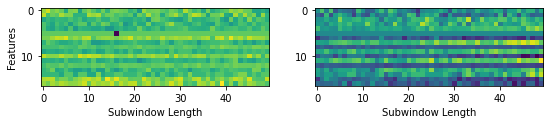

In [29]:
randint = np.random.randint(low=0, high=X_train_norm.shape[0], size=2)
fig, ax = plt.subplots(1, 2, figsize=(9,2))
ax[0].set_ylabel("Features");
for i, l in enumerate(randint):
    ax[i].imshow(X_train_norm[l])
    ax[i].set_xlabel("Subwindow Length");
    

Additionally, a Dense Neural Network was created due to the easy and fast implementation. Though the results are good, a disadvantage of DNNs is, that the input vector is usally one-dimensional and the subwindow has to be flattened. Hence, the invariant time information is used only implicit. To make use of the time step information, a recurrent neural network was created. RNNs are especially designed to work with sequential data, since they implement 'memory gates'.


The performance of model versions and is evaluated with the *RUL Score* which was introduced in the first chapter. The Score lets us compare the models respecitvely as well. 

### Preprocessing and Descriptive Statistics

The dataset is split into coherent subwindows, which serve as sequential data input for the models. Additionally, the features are obeserved manually and truncated, if they contain only few information about degradation. Namely, the features with sensor numbers 2, 3, 7, 8, 12, 18, 20, 21 are removed from the dataset.  Lastly, the features are normalized and split into training-, validation and testing data.


In [30]:
# manual feature selection
manual_feature_selection = list(FEATURES)
for i in reversed([2, 3, 7, 8, 12, 18, 20, 21]):
    manual_feature_selection.pop(i)

pipeline_kwargs = dict(input_file=INPUT_FILE_TRAIN,
                       subwindow_features=manual_feature_selection,
                       min_window_length=WINDOW_LENGTH,
                       subwindows=SUBWINDOWS,
                       subwindow_length=SUBWINDOW_LENGTH,
                       subwindow_target=SUBWINDOW_TARGET,
                       maximize_subwindows=MAXIMIZE_SUBWINDOWS,
                       shuffle_subwindows=True,
                       percentage_training=50,
                       percentage_test=25,
                       splitting_feature="unit_number",
                       regression_feature="time_in_cycles",
                       target_feature_name="target",
                       target_clip_lower=TARGET_CLIP_LOWER,
                       target_min=TARGET_MIN,
                       target_clip_upper=TARGET_CLIP_UPPER,
                       target_max=TARGET_MAX,
                       fixed_dataframe_assignment=True,
                       sort_dataframes_after_splitting=False)

X_train_norm, y_train, time_in_cycles_train, unit_train,\
        X_test_norm, y_test, time_in_cycles_test, unit_test,\
        X_val_norm, y_val, time_in_cycles_val, unit_val, norm_parameter_regression = pipeline_level_0(**pipeline_kwargs)



Chosen splitting [%]:
Training:           50
Test:               25
Validation:         25
'first_list_indices':                      [83 53 70 45 44 39 22 80 10  0 18 30 73 33 90  4 76 77 12 31 55 88 26 42
 69 15 40 96  9 72 11 47 85 28 93  5 66 65 35 16 49 34  7 95 27 19 81 25
 62 13]
'second_list_indices' (before splitting):  [ 1  2  3  6  8 14 17 20 21 23 24 29 32 36 37 38 41 43 46 48 50 51 52 54
 56 57 58 59 60 61 63 64 67 68 71 74 75 78 79 82 84 86 87 89 91 92 94 97
 98 99]
'second_list_indices' (after splitting):   [36 82 63 92 43 98 58 57 67 48 32  8 78 21  6 17 86 94 97 38 23 41 56 71
 64]
'third_list_indices':                      [ 1  2  3 14 20 24 29 37 46 50 51 52 54 59 60 61 68 74 75 79 84 87 89 91
 99]


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:06<00:00,  4.04it/s]


Len invalid features:	 0
Invalid features are:	 [] 

Len invalid features:	 0
Invalid features are:	 [] 

Len invalid features:	 0
Invalid features are:	 [] 

Number of dataframes:                     100

Shape 'X_train' before normalization:     (7892, 16, 50)
Shape 'X_train' after normalization:      (7892, 16, 50)
Shape 'y_train':                          (7892, 1)
Shape 'time_in_cycles_train':             (7892, 50)
Shape 'unit_train':                       (7892, 1)

Shape 'X_test' before normalization:      (3667, 16, 50)
Shape 'X_test_norm' after normalization:  (3667, 16, 50)
Shape 'y_test':                           (3667, 1)
Shape 'time_in_cycles_test':              (3667, 50)
Shape 'unit_test':                        (3667, 1)

Shape 'X_val' before normalization:       (4072, 16, 50)
Shape 'X_val_norm' after normalization:   (4072, 16, 50)
Shape 'y_val':                            (4072, 1)
Shape 'time_in_cycles_val':               (4072, 50)
Shape 'unit_val':              

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:09<00:00, 10.44it/s]


Figure not saved


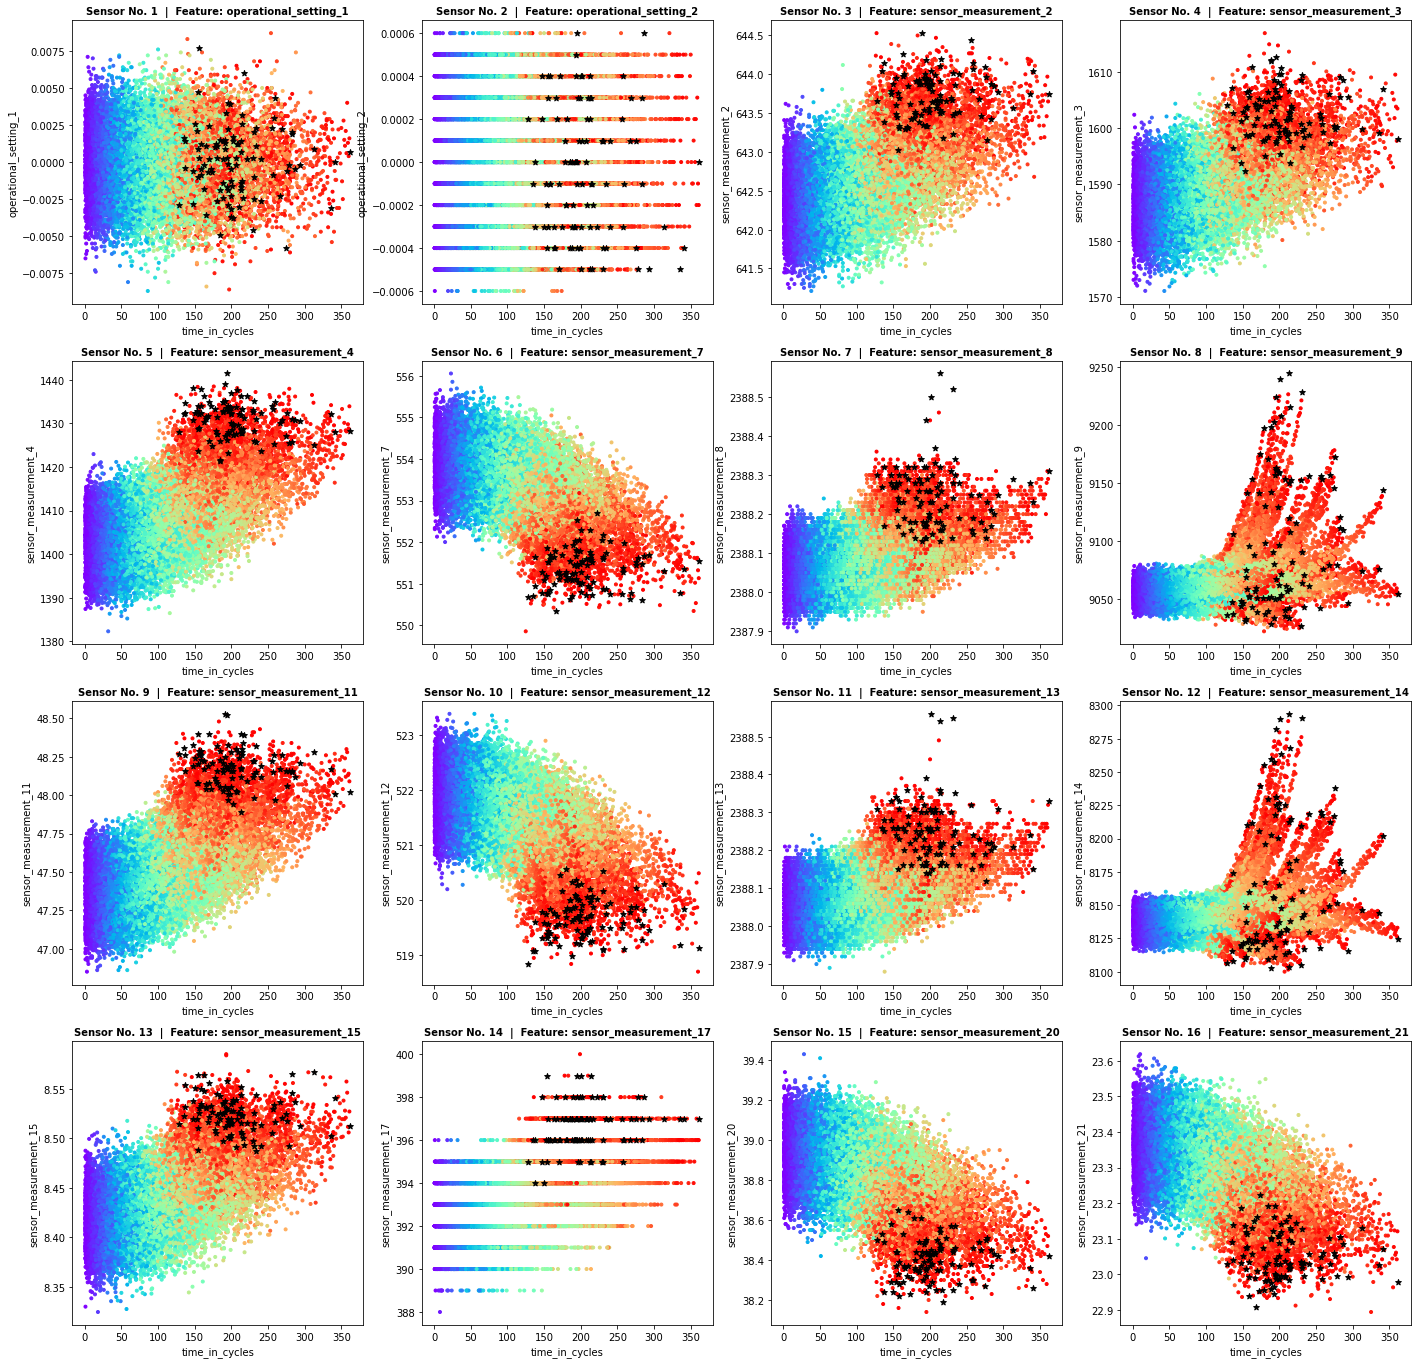

In [31]:
feature = "unit_number"

list_of_dataframes = subdivide_dataframe_by_feature(INPUT_FILE_TRAIN,
                                                    feature)

# plot the truncated dataset
plot_all_features_for_all_units(list_of_dataframes,
                                features=manual_feature_selection,
                                colormap_feature="time_in_cycles",
                                number_of_columns=4,
                                saving_path=r".\Plots",
                                save_fig=False,
                                plot_format="png")

### CNN Model on C-MAPSS Training Dataset
Neural Network with 1-dimensional convolutional layers on the manually truncated Dataset. It consists of 
- five 1-dimensional convolutional layers, which extract the features out of the subwindows by learning filters
- two fully connected dense layer which project the extracted features on the labels to make a prediction

In [32]:
convRegressor = NeuralNetRegressor(ConvRegressor,
                               lr                 = 1e-4,
                               batch_size         = 32,
                               max_epochs         = MAX_EPOCHS,
                               criterion          = nn.L1Loss,  #nn.MSELoss,  # nn.L1Loss,
                               optimizer          = torch.optim.Adam,

                               module__start_filters = 16, 
                               module__channels      = X_train_norm.shape[1], 
                               module__seq_length    = 32,

                               train_split        = predefined_split(skorch.dataset.Dataset(X_val_norm, y_val)),
                               device             = DEVICE,
                               verbose            = True,
                               callbacks          = [CHECKPOINT, 
                                                    LRScheduler(torch.optim.lr_scheduler.ReduceLROnPlateau, patience=8, verbose=True),
                                                    skorch.callbacks.EarlyStopping(monitor='valid_loss', patience=10, threshold=0.0001, threshold_mode='rel'),
                                                    HistoryPlotter(per_epoch=True)]
                               )



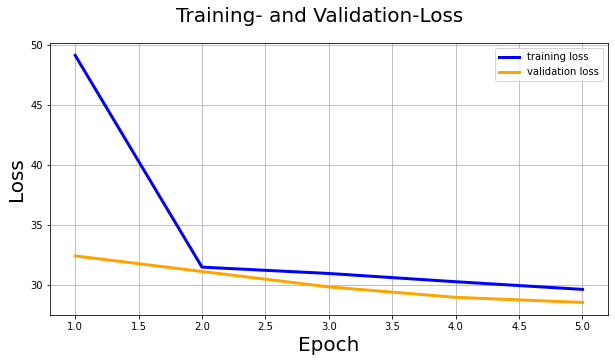

Epoch Duration: 13.38 s, Total Duration 0.87 min
      5       29.6110       28.5201     +  13.3762


In [33]:
conv_preds = convRegressor.fit(X_train_norm, y_train)

R2-Score:	 0.39928014995557926
RUL-Score:	 1136852.0973124504


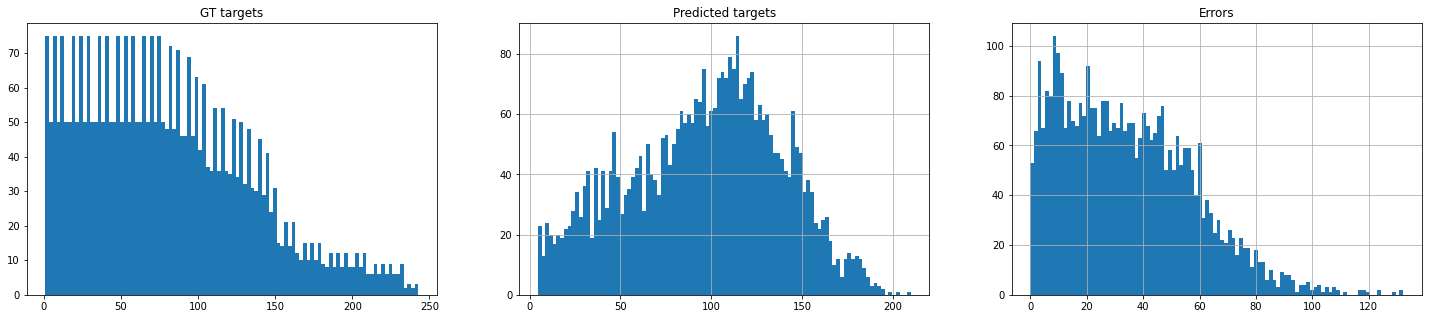

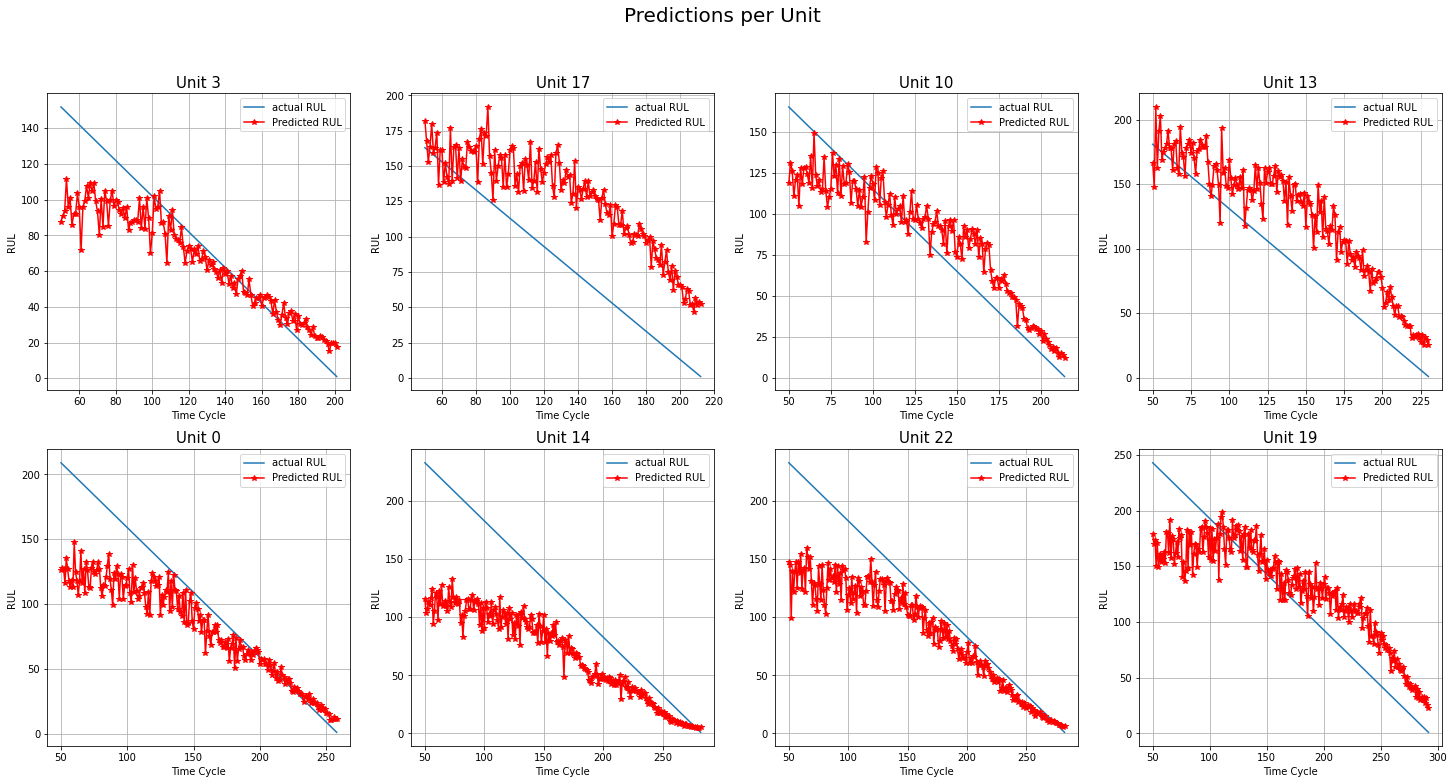

In [34]:
conv_preds = convRegressor.predict(X_test_norm)
evaluate_regression_model(conv_preds, y_test, unit_test, time_in_cycles_test)

### DNN Model on C-MAPSS Training Dataset
Dense Neural Network Training on the manually truncated Dataset

In [35]:
dnnRegressor = NeuralNetRegressor(DNNRegressor,
                               lr                 = 0.00001,
                               batch_size         = 32,
                               max_epochs         = MAX_EPOCHS,
                               criterion          = nn.MSELoss,  # nn.L1Loss,
                               optimizer          = torch.optim.Adam,

                               module__input_size = X_train_norm.shape[1:],
                               module__n_layer    = 3, 
                               module__nh         = np.array([10, 1, 1]) * X_train_norm.shape[1] * X_train_norm.shape[2], 
                               module__hactfn     = [torch.sigmoid, torch.sigmoid, None], #[nn.Sigmoid(), nn.Sigmoid()], 
                               module__p_dropout  = None, 
                               module__output_size= 1, 
                               module__oactfn     = F.relu, #nn.ReLU(),
                               module__device     = DEVICE,

                               train_split        = predefined_split(skorch.dataset.Dataset(X_val_norm, y_val)),
                               device             = DEVICE,
                               verbose            = True,
                               callbacks          = [CHECKPOINT, 
                                                    LRScheduler(torch.optim.lr_scheduler.ReduceLROnPlateau, patience=3, verbose=True),
                                                    skorch.callbacks.EarlyStopping(monitor='valid_loss', patience=10, threshold=0.0001, threshold_mode='rel'),
                                                    HistoryPlotter(per_epoch=True)]
                               )


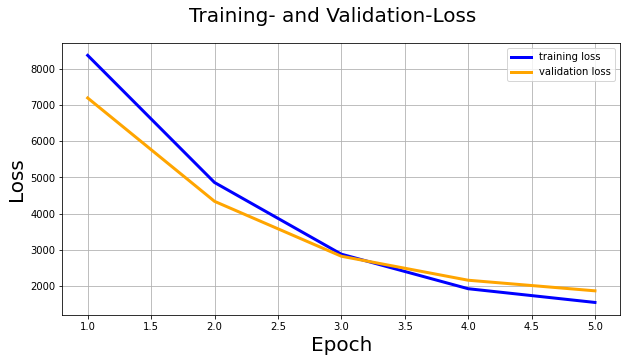

Epoch Duration: 43.07 s, Total Duration 3.63 min
      5     1542.1451     1863.4236     +  43.0740


In [36]:
dnnRegressor.fit(X_train_norm, y_train);

Now we're using the trained model to predict the RUL of the test dataset. The prediction will be used to quantify the model's quality.

R2-Score:	 0.474999177288005
RUL-Score:	 768792.2006778717


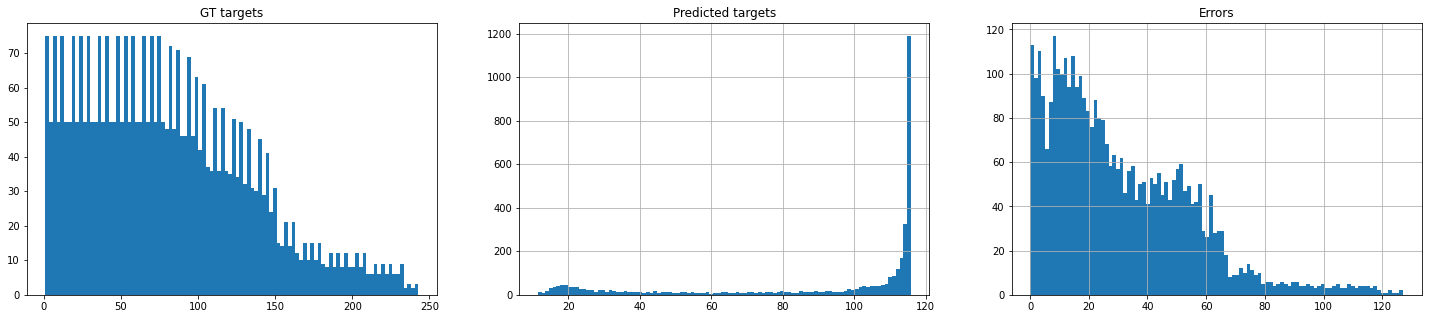

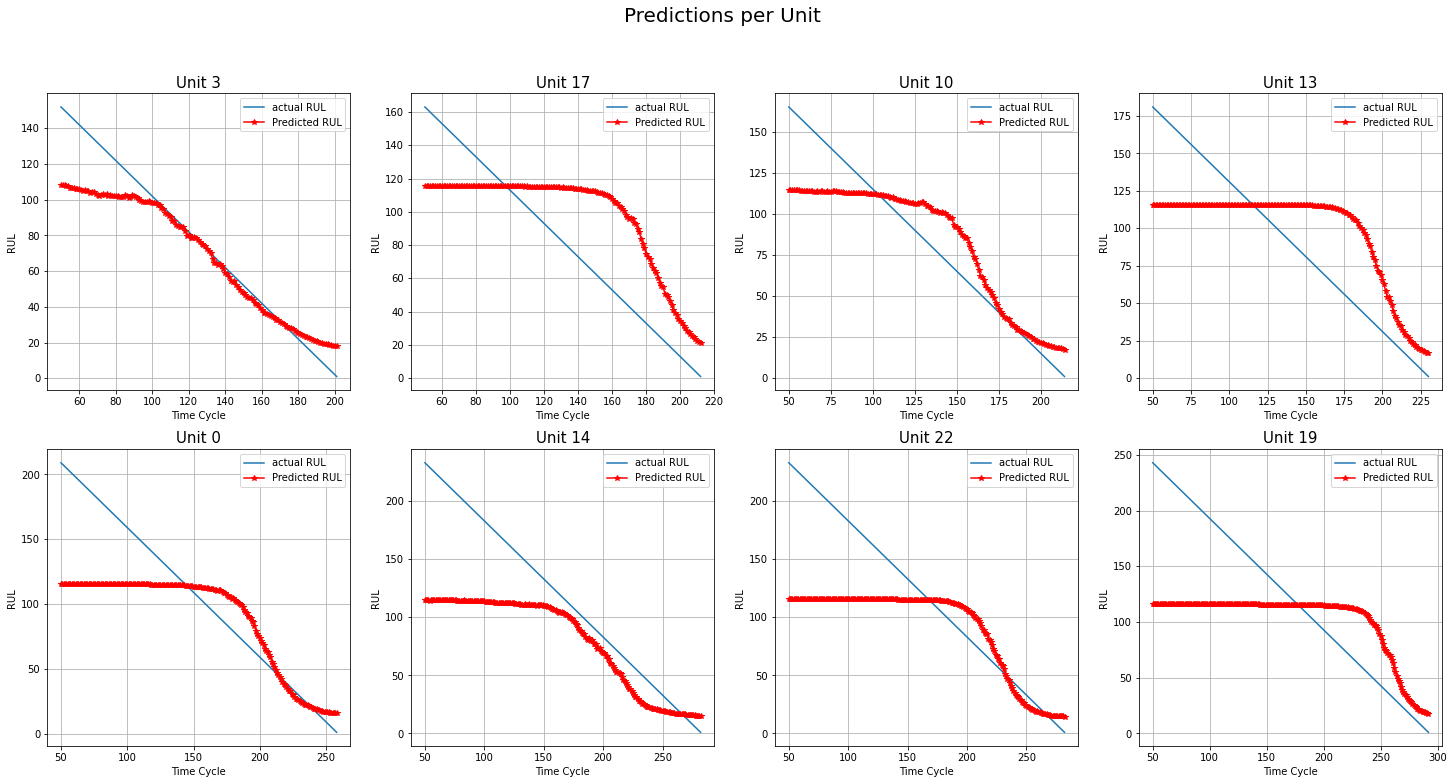

In [37]:
with open(CHECKPOINT.dirname + "/" + CHECKPOINT.f_pickle, "rb") as f:
    dnnRegressor = pickle.load(f)

dnn_preds = dnnRegressor.predict(X_test_norm)

evaluate_regression_model(dnn_preds, y_test, unit_test, time_in_cycles_test)

---
### RNN Model on C-MAPSS Training Dataset
Recurrent Neural Network Training on the manually truncated C-MAPSS Dataset. The goal is to create a regressor which predicts the 'Remaining Useful Lifetime (RUL)' reliable. <br> 

Recurrent Neural Networks are a special type of Neural Networks which perform especially well on sequential input data. Therefore, they are well suited for 'Remaining Useful Lifetime' predictions, but also for speech recognition or image capturing. This is due to several network characteristics: 
- **Variable input size:** In contrast to classical ANNs, the number of 'input neurons' is not defined by the input length but only by the number of input feautes. The input length (or sequence length in the context of RNNs) defines the number of layers of a RNN Cell. As a consequence the RNN can deal with variable input size. Since in this project, the data is preprocessed with windowing functions, this characteristic is not used.
- **Memory cells:** hidden states are propagated through the cells of a RNN Layer. The hidden states are computed with the help of gates (e.g. forget gate and remember gate in the case of 'Gated Recurrent Units' or even memory cells in case of 'Long Short-Term Memory'), which are additional parameters to be learned. As a result, the Network is learning a memory, which helps to analyse a sequenece and make a reliable prediction.
- **Variable output size:** The prediction (hidden state at any desired time) sequence can be of any length. In our project, the output is either the first sequence element, the middle element or the last element according to the target definition (see Preprocessing chapter). This is a so called 'many to one' network. Anyway, taking the whole dataframe as input and returning the whole RUL function as output would be possible as well and will be implemented in a future version (so called 'many to many' network).

<br> 
**Model Architecture:** <br>
The general model architecture consists of a stack of RNN Cells (LSTM- or GRU-Type) to extract features out of the transient information and a dense layer to map those features on the RUL target. RNN Cells itself iterate over every timestep of the sequential data, so their depth is dependent on the sequence length. Sind the model follows the 'many to one' approach, the RUL target is a scalar, so only the feature output for the last timestamp in the last RNN Cell is used.

<br>

**Model Design Parameters** <br>

To embedd the RNN Model in our project and be consistent with the other created models, we have focused on the 'many to one' network approach in the scope of this project. We used the NeuralNetRegressor of the skorch framework as a wrapper for our Recurrent Neural Network Module. When designing the network, the focus was on giving the user a wide span of configuration possibilities. Configuration arguments, when initialising the network are:
- **sequence length:** The model can work with 
- **number of hidden features:** determines the number of neurons in an rnn layer. Must not be mixed up with the depth of one RNN Cell, which is determined by the sequence length.
- **number of layers:** number of stacked RNN Cells. When greater than one, it creates a Deep-RNN.
- **hidden activation function:** activation function which recieves the recurrent layer output features as inputs.
- **activation function:** activation function which recieves the output features of the dense layer as input. 
- **Dropout Layer:** Dropout layer can be placed behind every RNN Cell as an option against overfitting
- **RNN Cell Type:** Can be set to LSTM or GRU. Both types avoid appearance of vanishing and exploding gradients when performing the backpropagation with a system of gating units.  GRUs work with 'remember-' and 'forget-gates', whereas LSTMs introduce an additional memory cell which is learned.
- **Bidirectionality:** Traditionally RNN types 'remember' data only in forward direction, which means that the output at one point in the sequence does not use the future information. Since this information is theoretically available the bidirectional approach can be used which can learn dependencies in forward and backward direction.
- **State**: RNNs can be classified in stateless and stateful types. In the scope of stateless types, the memory persists only inside of one sequence. The initial state for the first element in the sequence is initialised in every forward pass. Stateful RNNs on the other hand use the memory learned in one sequence and pass it to the next sequence in form of initial hidden states. In most (or possibly any) cases the dataset should not be shuffled when using stateful RNNs and the sequences should not overlap too much.

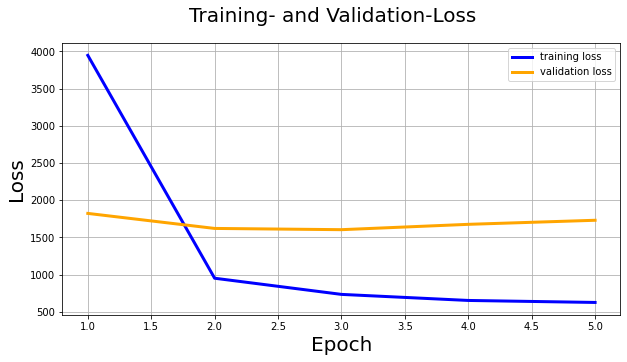

Epoch Duration: 21.80 s, Total Duration 1.85 min
      5      625.0070     1729.3678        21.7989


In [38]:
rnnRegressor = NeuralNetRegressor(
                                  RNNRegressor,
                                  max_epochs      = MAX_EPOCHS,
                                  lr              = 0.0002, # 0.0005, #0.0005,
                                  batch_size      = 32, 
                                  criterion       = nn.MSELoss,  # nn.L1Loss,
                                  optimizer       = torch.optim.SGD,  #Adam, ASGD, Adagrad

                                  module__input_size = X_train_norm.shape,
                                  module__no      = 1,
                                  module__nh      = int(X_train_norm.shape[1] * 5), 
                                  module__nlayers = 2, 
                                  module__hactfn  = nn.Tanh(),  # nn.Tanh(), nn.Sigmoid(), nn.LeakyReLU(), nn.Sigmoid()
                                  module__actfn   = nn.ReLU(),
                                  module__pDropout= 0.6,
                                  module__rnnType = "gru",
                                  module__state   = "stateless",
                                  module__bidir   = False,
                                  module__device  = DEVICE,

                                  device          = DEVICE,
                                  verbose         = True,
                                  train_split     = predefined_split(skorch.dataset.Dataset(X_val_norm, y_val)),
                                  callbacks       = [CHECKPOINT, 
                                                    LRScheduler(torch.optim.lr_scheduler.ReduceLROnPlateau, patience=3, verbose=True),
                                                    skorch.callbacks.EarlyStopping(monitor='valid_loss', patience=10, threshold=0.0001, threshold_mode='rel'),
                                                    HistoryPlotter(per_epoch=True)]
                                  )
rnnRegressor.fit(X_train_norm, y_train);

NOTE: The results heavily depend on the initial weights. It might take some runs to archieve good results. 


R2-Score:	 0.46102133191541206
RUL-Score:	 998859.4974502325


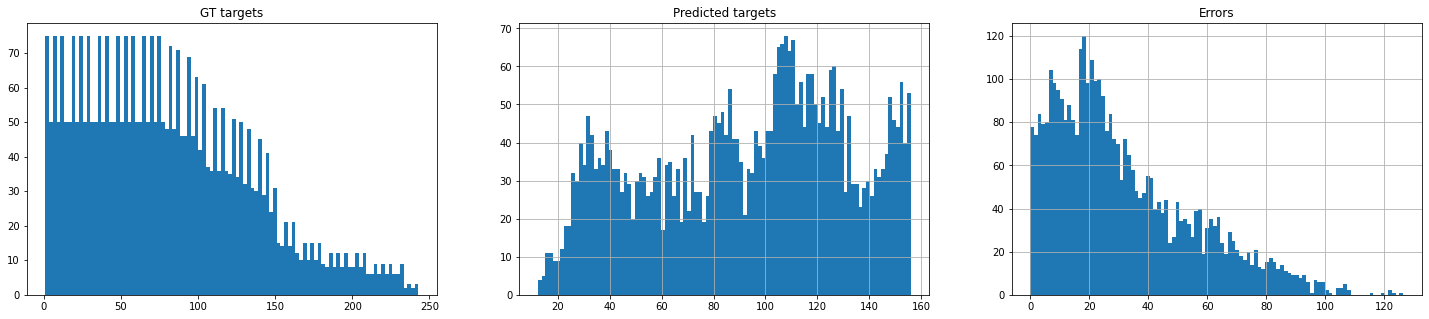

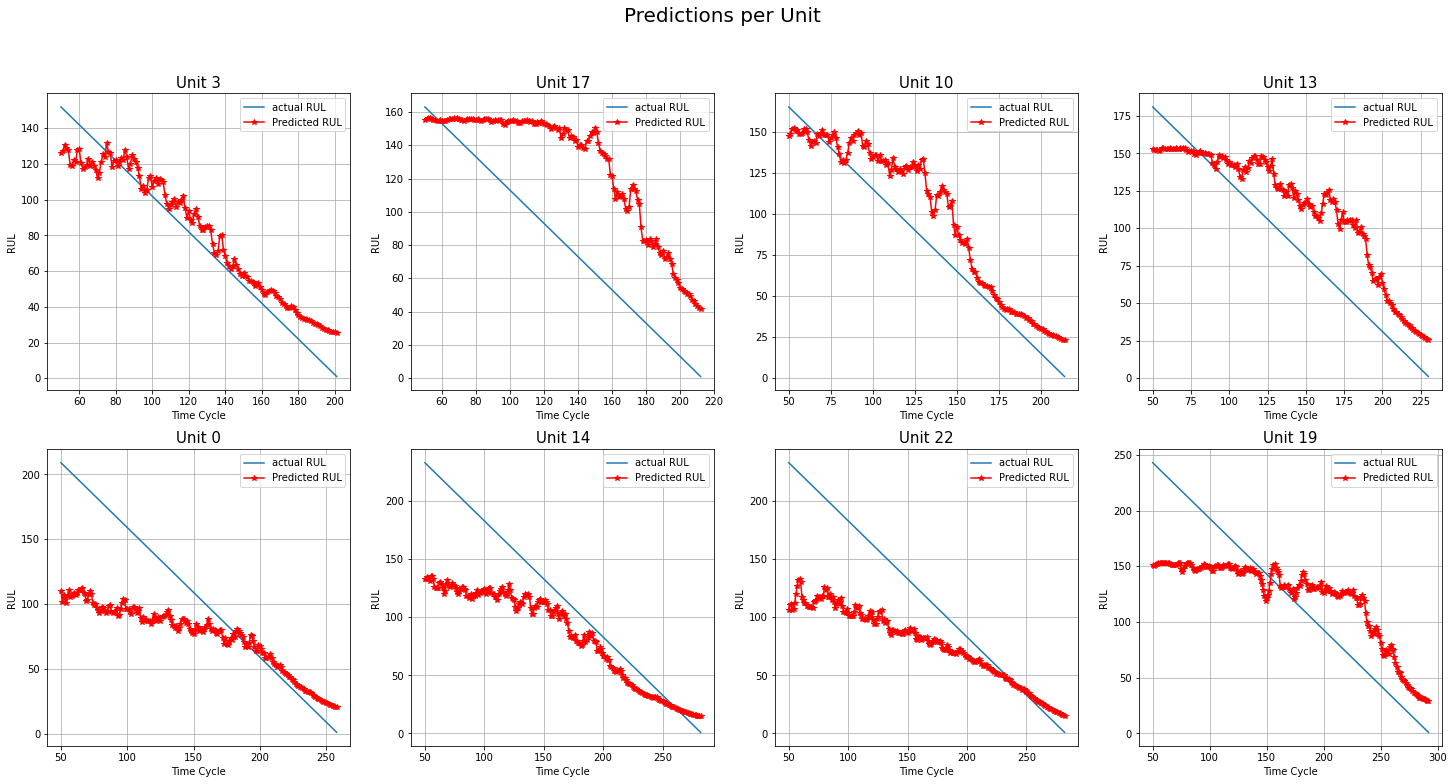

In [39]:
with open(CHECKPOINT.dirname + "/" + CHECKPOINT.f_pickle, "rb") as f:
    rnnRegressor = pickle.load(f)

rnn_preds = rnnRegressor.predict(X_test_norm)

evaluate_regression_model(rnn_preds, y_test, unit_test, time_in_cycles_test)

The predictions on the testset were really good at first glance. The RUL Score was low with **860** (since the RUL Score is the sum of exponential functions, it increases with large gradients). The R2 score was near 1 with **0.98**. It can be seen that the model struggels a bit when degradation effects are not fully developed yet, but the prediction gets better, when the unit reaches the end of life and fault features are more clear. Anyway, we were a bit suprised and were questioning the results and hyperparameters.

The splitting method for the dataset was **Level 2** split, which means that the subwindows are generated from all units and then splitted into training, validation and testing. The number of generated subwindows was maximized to recieve as many sequences as possible. As a result, two consecutive subwindows A and B were overlapping and containing chunks of sequences AB, which have the same timestamp. Hence, if subwindow A is in the training set and B in the test set, the model has actually seen part of the series in the training already (it has kind of a Déjà vu). Therefore, the model was fitted perfeclty to the test data, since test data is so similar to the training data. But making predictions on a dataset, which is completeley different would lead to bad results.

Hence, for further investigations, the dataset was splitted by **Level 0** split, which means that first the units were splitted into testing, validation and training and following that, the windowing is performed. This ensures split set independece, since data of one unit can only be in one split set. 

Another Random Search Cross Validation was performed with subsequent manual finetuning.

The scores and the plots expose, that the training of the model is obviously harder with **Level 0** split, and the quality seems to decrease. The R2 score is at **0.90** and the RUL score is high with **3783**. Anyway, the model is more general and the testing set is not contaminated with data, the model has already seen during training.

Of course the model can be further improved. Due to limited computational power and time, we were limited in the number of training runs, even when the hyperparameters are not optimal yet. Another interesting approach would be to adapt the model to a 'many to many' type, where the output is the whole RUL function. In that case, the bidirectionallity option of the model would possibly increase the performance.


---
---
# **Classification based on principal components of the C-MAPSS Training Dataset**
---
---

## Function to add urgency label for classification to list of dataframes

In [40]:
def add_urgency_feature(dataframe,
                        target_feature_name="target",
                        urgency_indicator_name="Urgency_Indicator"):

    label_list = []
    target_series = dataframe[target_feature_name]
    for value in target_series:
        if value >= 201:
            label_list.append("Long")
        elif value >= 126:
            label_list.append("Medium")
        elif value >= 51:
            label_list.append("Short")
        else:
            label_list.append("Urgent")

    dataframe[urgency_indicator_name] = label_list

    return dataframe



In [41]:
list_of_dataframes = subdivide_dataframe_by_feature(INPUT_FILE_TRAIN)
test_df = list_of_dataframes[0].copy()
add_target_feature(test_df)
add_urgency_feature(test_df)
test_df

unit_number  time_in_cycles  operational_setting_1  \
0              1               1                -0.0007   
1              1               2                 0.0019   
2              1               3                -0.0043   
3              1               4                 0.0007   
4              1               5                -0.0019   
..           ...             ...                    ...   
187            1             188                -0.0067   
188            1             189                -0.0006   
189            1             190                -0.0027   
190            1             191                -0.0000   
191            1             192                 0.0009   

     operational_setting_2  operational_setting_3  sensor_measurement_1  \
0                  -0.0004                  100.0                518.67   
1                  -0.0003                  100.0                518.67   
2                   0.0003                  100.0                518.67   
3                   0.0000                  100.0                518.67   
4                  -0.0002                  100.0                518.67   
..                     ...                    ...                   ...   
187                 0.0003                  100.0                518.67   
188                 0.0002                  100.0                518.67   
189                 0.0001                  100.0                518.67   
190                -0.0004                  100.0                518.67   
191                -0.0000                  100.0                518.67   

     sensor_measurement_2  sensor_measurement_3  sensor_measurement_4  \
0                  641.82               1589.70               1400.60   
1                  642.15               1591.82               1403.14   
2                  642.35               1587.99               1404.20   
3                  642.35               1582.79               1401.87   
4                  642.37               1582.85               1406.22   
..                    ...                   ...                   ...   
187                643.75               1602.38               1422.78   
188                644.18               1596.17               1428.01   
189                643.64               1599.22               1425.95   
190                643.34               1602.36               1425.77   
191                643.54               1601.41               1427.20   

     sensor_measurement_5  ...  sensor_measurement_14  sensor_measurement_15  \
0                   14.62  ...                8138.62                 8.4195   
1                   14.62  ...                8131.49                 8.4318   
2                   14.62  ...                8133.23                 8.4178   
3                   14.62  ...                8133.83                 8.3682   
4                   14.62  ...                8133.80                 8.4294   
..                    ...  ...                    ...                    ...   
187                 14.62  ...                8117.69                 8.5207   
188                 14.62  ...                8117.51                 8.5183   
189                 14.62  ...                8112.58                 8.5223   
190                 14.62  ...                8114.61                 8.5174   
191                 14.62  ...                8110.93                 8.5113   

     sensor_measurement_16  sensor_measurement_17  sensor_measurement_18  \
0                     0.03                    392                   2388   
1                     0.03                    392                   2388   
2                     0.03                    390                   2388   
3                     0.03                    392                   2388   
4                     0.03                    393                   2388   
..                     ...                    ...                    ...   
187                   0.0

## PCA

In [42]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [43]:
# save sensor data in np.array for further processing
X = INPUT_FILE_TRAIN[SENSOR_FEATURES]
'''
# What happens if features are identical; Therefore add a duplicated feature series
X = pd.concat([X, INPUT_FILE_TRAIN[SENSOR_FEATURES[0]]], axis=1)
# Rename features
X.columns = pd.io.parsers.ParserBase({'names': X.columns})._maybe_dedup_names(X.columns)
# Sort features
X = X.reindex(sorted(X.columns), axis=1)

# Alternative:
#X["Sensor_duplicate"] = INPUT_FILE_TRAIN[SENSOR_FEATURES[0]]
'''


m = X.shape[0]
n = X.shape[1]

# Standardize data
scaler = StandardScaler()
Z = scaler.fit_transform(X)

# Run PCA
pca = PCA().fit(Z)
coeff = (pca.components_).T
score = pca.transform(Z)
variance_ratio = pca.explained_variance_ratio_

# fit and transform at same time
pc_array = PCA().fit_transform(Z)

assert (score[0].round(3) == pc_array[0].round(3)).all()

In [44]:
X

sensor_measurement_1  sensor_measurement_2  sensor_measurement_3  \
0                    518.67                641.82               1589.70   
1                    518.67                642.15               1591.82   
2                    518.67                642.35               1587.99   
3                    518.67                642.35               1582.79   
4                    518.67                642.37               1582.85   
...                     ...                   ...                   ...   
20626                518.67                643.49               1597.98   
20627                518.67                643.54               1604.50   
20628                518.67                643.42               1602.46   
20629                518.67                643.23               1605.26   
20630                518.67                643.85               1600.38   

       sensor_measurement_4  sensor_measurement_5  sensor_measurement_6  \
0                   1400.60                 14.62                 21.61   
1                   1403.14                 14.62                 21.61   
2                   1404.20                 14.62                 21.61   
3                   1401.87                 14.62                 21.61   
4                   1406.22                 14.62                 21.61   
...                     ...                   ...                   ...   
20626               1428.63                 14.62                 21.61   
20627               1433.58                 14.62                 21.61   
20628               1428.18                 14.62                 21.61   
20629               1426.53                 14.62                 21.61   
20630               1432.14                 14.62                 21.61   

       sensor_measurement_7  sensor_measurement_8  sensor_measurement_9  \
0                    554.36               2388.06               9046.19   
1                    553.75               2388.04               9044.07   
2                    554.26               2388.08               9052.94   
3                    554.45               2388.11               9049.48   
4                    554.00               2388.06               9055.15   
...                     ...                   ...                   ...   
20626                551.43               2388.19               9065.52   
20627                550.86               2388.23               9065.11   
20628                550.94               2388.24               9065.90   
20629                550.68               2388.25               9073.72   
20630                550.79               2388.26               9061.48   

       sensor_measurement_10  ...  sensor_measurement_12  \
0                        1.3  ...                 521.66   
1                        1.3  ...                 522.28   
2                        1.3  ...                 522.42   
3                        1.3  ...                 522.86   
4                        1.3  ...                 522.19   
...                      ...  ...                    ...   
20626                    1.3  ...                 519.49   
20627                    1.3  ...                 519.68   
20628                    1.3  ...                 520.01   
20629                    1.3  ...                 519.67   
20630                    1.3  ...                 519.30   

       sensor_measurement_13  sensor_measurement_14  sensor_measurement_15  \
0                    2388.02                8138.62                 8.4195   
1                    2388.07                8131.49                 8.4318   
2                    2388.03                8133.23                 8.4178   
3                    2388.08                8133.83                 8.3682   
4                    2388.04                8133.80                 8.4294   
...                      ...                    ...                    ...   
20626                2388.26         

### Further data-preprocessing

In [45]:
# Cast 'pc_array' to dataframe
PC_FEATURES = ["PC_%s" % str(x) for x in range(1, pc_array.shape[1] + 1)]
pc_df = pd.DataFrame(pc_array,
                     columns=PC_FEATURES)


list_of_dataframes = subdivide_dataframe_by_feature(INPUT_FILE_TRAIN)

for dataframe in list_of_dataframes:
    add_target_feature(dataframe)
    add_urgency_feature(dataframe)

expanded_df = pd.concat(list_of_dataframes, axis=0)

target_df = expanded_df["target"]
urgency_series = expanded_df["Urgency_Indicator"]

---
# Regression Neural Network model on C-MAPSS Test Dataset

We can use the Neural Networks which were created for the regression problem to perform predictions on the C-MAPSS Test Dataset.

### Preprocessing and Desciptive *Statistics*

First, the Dataset needs to be prepared:
- createcopy the test-data and truncate it if required
- add the unit number
- create Subwindows for remaining dataset
- normalize data
- perform test

In [46]:
list_of_test_dataframes = subdivide_dataframe_by_feature(INPUT_FILE_TEST)

for test_df, RUL in zip(list_of_test_dataframes, INPUT_FILE_RUL):
    add_target_feature(test_df)
    test_df["target"] = test_df["target"] + RUL
    if TARGET_CLIP_UPPER:
        test_df["target"] = test_df["target"].clip(upper=TARGET_MAX)
    add_urgency_feature(test_df)

test_data = pd.concat(list_of_test_dataframes, axis=0)
test_urgency_series = test_data["Urgency_Indicator"]

In [47]:

# Copy the Test Dataset
data_testset = test_data.copy().drop(columns="Urgency_Indicator")

# Sensor Features
features_testset = manual_feature_selection

# create List of Dataframes
list_of_dataframes_testset = subdivide_dataframe_by_feature(data_testset, feature="unit_number", drop_feature=False)

# create subwindows out of remaining features for all dataframes
all_feature_values_testset, all_target_values_testset = get_subwindows_from_dataframes(list_of_dataframes_testset,
                                                                                       features=["unit_number"] + ["time_in_cycles"] + features_testset,
                                                                                       subwindows=40,
                                                                                       maximize_subwindows=True,
                                                                                       subwindow_length=SUBWINDOW_LENGTH,
                                                                                       subwindow_target='max',
                                                                                       shuffle=False)

# added the feature ["unit_number"] and ["time_in_cycles"] just to save it in 'all_unit_numbers_testset' and 'all_time_in_cycles_testset' for later. Col can be dropped by sclicing.
all_unit_numbers_testset   = all_feature_values_testset[:, 0, :]
all_time_in_cycles_testset = all_feature_values_testset[:, 1, :]
all_feature_values_testset  = all_feature_values_testset[:,2:,:]

print(all_unit_numbers_testset.shape)
print(all_unit_numbers_testset)
all_unit_numbers_testset = all_unit_numbers_testset[:,0]
print(all_unit_numbers_testset.shape)
print(all_time_in_cycles_testset.shape)

# normalize the data since the training data was normalized as well
X_testset = all_feature_values_testset
Y_testset = all_target_values_testset
X_testset_norm, _ = normalize_feature_values(features_array=all_feature_values_testset, train_standardization_params=norm_parameter_regression)

print("Shape 'X_regres_test_norm':\t", X_testset_norm.shape)
print("Shape 'Y_regres_test':\t\t\t\t", Y_testset.shape)
print("\n")
    


  4%|███▎                                                                              | 4/100 [00:00<00:03, 28.65it/s]

DataFrame can't be used
DataFrame can't be used
DataFrame can't be used


 10%|████████                                                                         | 10/100 [00:00<00:05, 15.43it/s]

DataFrame can't be used
DataFrame can't be used


 14%|███████████▎                                                                     | 14/100 [00:00<00:06, 12.76it/s]

DataFrame can't be used
DataFrame can't be used


 21%|█████████████████                                                                | 21/100 [00:01<00:08,  9.62it/s]

DataFrame can't be used


 28%|██████████████████████▋                                                          | 28/100 [00:02<00:05, 13.48it/s]

DataFrame can't be used
DataFrame can't be used


 34%|███████████████████████████▌                                                     | 34/100 [00:02<00:05, 11.60it/s]

DataFrame can't be used


 41%|█████████████████████████████████▏                                               | 41/100 [00:03<00:04, 12.93it/s]

DataFrame can't be used


 45%|████████████████████████████████████▍                                            | 45/100 [00:03<00:04, 12.13it/s]

DataFrame can't be used


 47%|██████████████████████████████████████                                           | 47/100 [00:03<00:03, 13.26it/s]

DataFrame can't be used
DataFrame can't be used


 51%|█████████████████████████████████████████▎                                       | 51/100 [00:04<00:03, 12.59it/s]

DataFrame can't be used


 59%|███████████████████████████████████████████████▊                                 | 59/100 [00:04<00:03, 11.37it/s]

DataFrame can't be used


 64%|███████████████████████████████████████████████████▊                             | 64/100 [00:05<00:04,  8.59it/s]

DataFrame can't be used
DataFrame can't be used


 70%|████████████████████████████████████████████████████████▋                        | 70/100 [00:05<00:02, 12.53it/s]

DataFrame can't be used
DataFrame can't be used


 76%|█████████████████████████████████████████████████████████████▌                   | 76/100 [00:06<00:01, 12.94it/s]

DataFrame can't be used


 80%|████████████████████████████████████████████████████████████████▊                | 80/100 [00:06<00:01, 13.64it/s]

DataFrame can't be used


 84%|████████████████████████████████████████████████████████████████████             | 84/100 [00:07<00:01, 11.26it/s]

DataFrame can't be used
DataFrame can't be used


 89%|████████████████████████████████████████████████████████████████████████         | 89/100 [00:07<00:00, 15.79it/s]

DataFrame can't be used
DataFrame can't be used


 97%|██████████████████████████████████████████████████████████████████████████████▌  | 97/100 [00:08<00:00, 12.05it/s]

DataFrame can't be used
DataFrame can't be used


 99%|████████████████████████████████████████████████████████████████████████████████▏| 99/100 [00:08<00:00, 12.70it/s]

DataFrame can't be used


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:08<00:00, 11.74it/s]


(7597, 50)
[[  3.   3.   3. ...   3.   3.   3.]
 [  3.   3.   3. ...   3.   3.   3.]
 [  3.   3.   3. ...   3.   3.   3.]
 ...
 [100. 100. 100. ... 100. 100. 100.]
 [100. 100. 100. ... 100. 100. 100.]
 [100. 100. 100. ... 100. 100. 100.]]
(7597,)
(7597, 50)
Len invalid features:	 0
Invalid features are:	 [] 

Shape 'X_regres_test_norm':	 (7597, 16, 50)
Shape 'Y_regres_test':				 (7597, 1)




100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:11<00:00,  9.07it/s]


Figure not saved


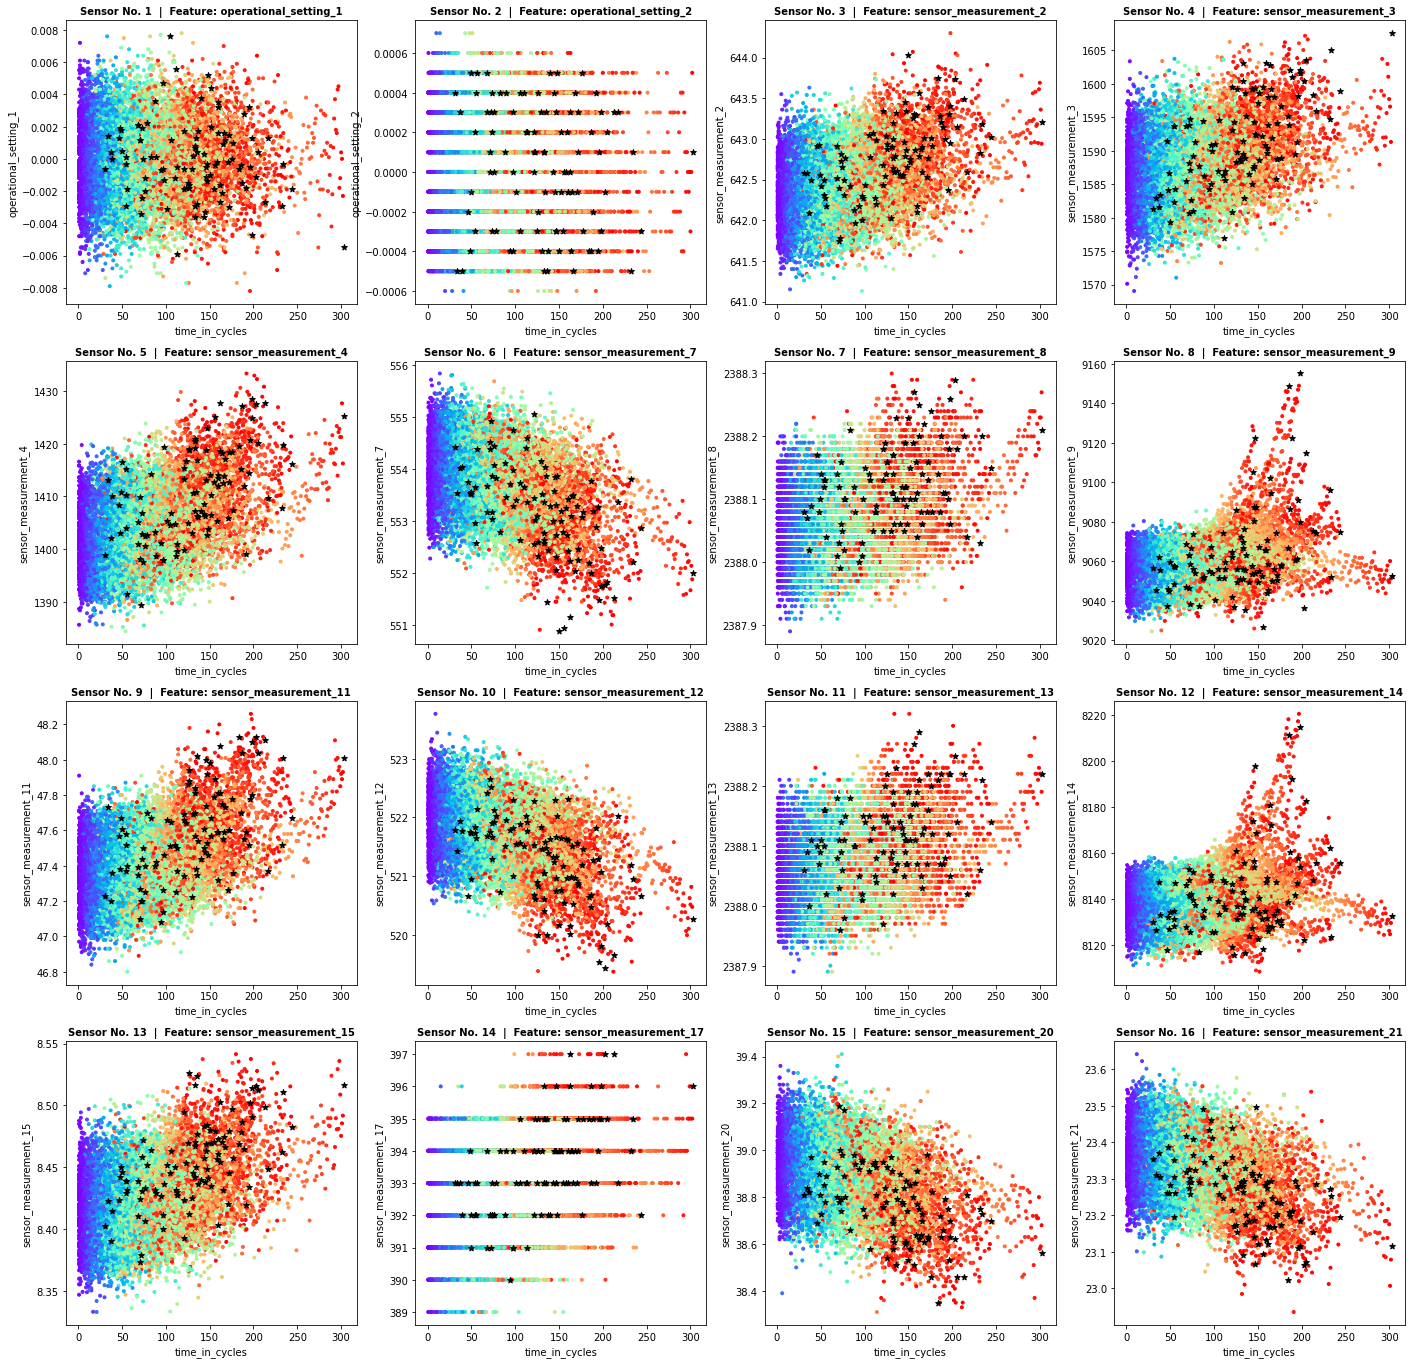

In [48]:
plot_all_features_for_all_units(list_of_dataframes_testset,
                                features=features_testset,
                                colormap_feature="time_in_cycles",
                                number_of_columns=4,
                                saving_path=r".\Plots",
                                save_fig=False,
                                plot_format="png")

---
### Model Inference
Make predictions with the models:
- Dense Neural Network,
- Recurrent Neural Network,

on the orginal (truncated) C-MAPSS Test Dataset can be used.

In [49]:
# Make predictions
preds_dnn_testset = dnnRegressor.predict(X_testset_norm)
preds_rnn_testset = rnnRegressor.predict(X_testset_norm)


In [50]:
# Evaluate Prediction
print("Dense Neural Network")
# evaluate_regression_model(preds_dnn_testset, Y_testset, all_unit_numbers_testset, all_time_in_cycles_testset)

Dense Neural Network


Recurrent Neural Network
R2-Score:	 -0.596478919164255
RUL-Score:	 249395961.04721534


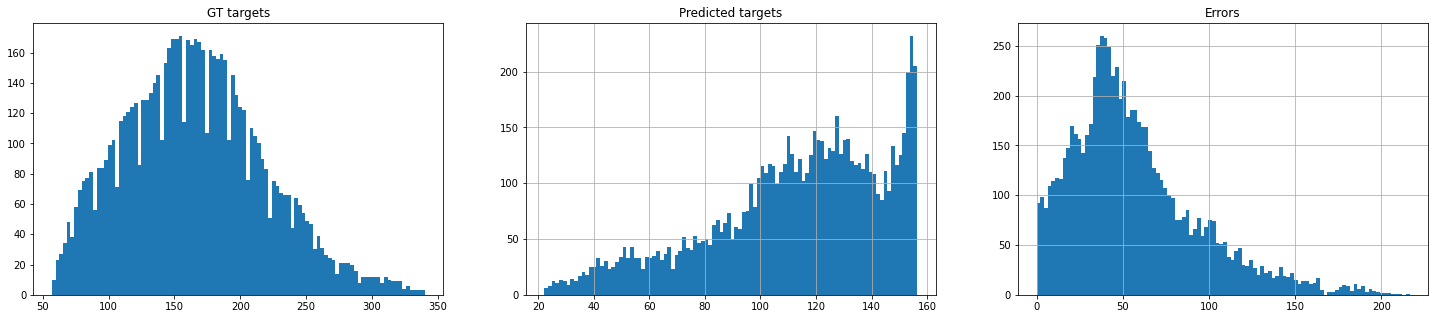

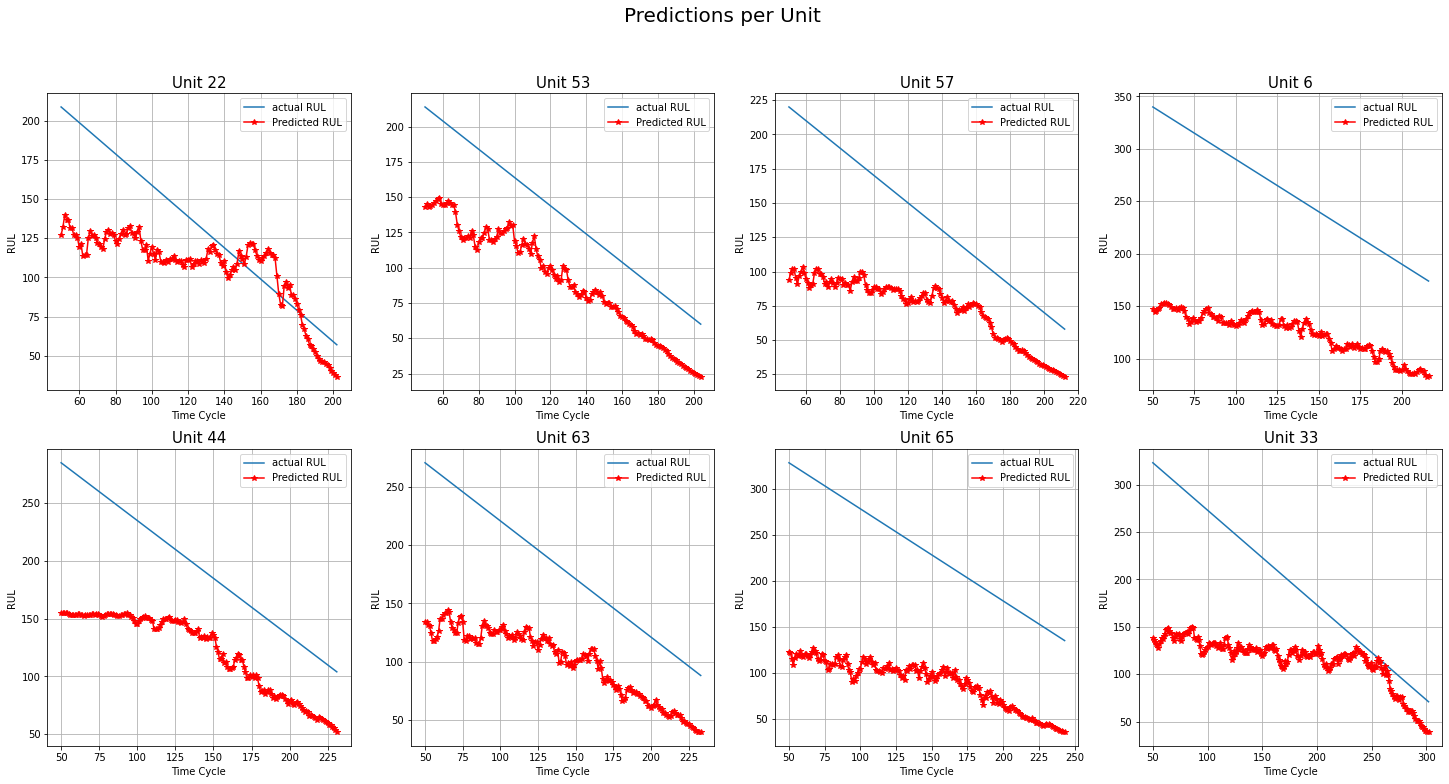

In [51]:
print("Recurrent Neural Network")
evaluate_regression_model(preds_rnn_testset, Y_testset, all_unit_numbers_testset, all_time_in_cycles_testset)

---
# Hyperparameter Study for Regression Models
For the Hyperparameter Study of the Regression Models the RandomSearchCV (CV: Crossvalidation) Funktion is used. To compare model iterations, the *RUL Score* is used as mentioned above. A low score means the model is predicting reliable RUL Values.

### Helper Function and Data Preparation

In [52]:
# Utility function to report best scores
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})"
                  .format(results['mean_test_score'][candidate],
                          results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")


Recreate Training and Validation Datasets for Hyperparameter Search with Cross Validation.


In [53]:
# manual feature selection
manual_feature_selection = list(FEATURES)
for i in reversed([2, 3, 7, 8, 12, 18, 20, 21]):
    manual_feature_selection.pop(i)

pipeline_kwargs = dict(input_file=INPUT_FILE_TRAIN,
                       subwindow_features=manual_feature_selection,
                       min_window_length=WINDOW_LENGTH,
                       subwindows=SUBWINDOWS,
                       subwindow_length=SUBWINDOW_LENGTH,
                       subwindow_target=SUBWINDOW_TARGET,
                       maximize_subwindows=MAXIMIZE_SUBWINDOWS,
                       shuffle_subwindows=True,
                       percentage_training=50,
                       percentage_test=25,
                       splitting_feature="unit_number",
                       regression_feature="time_in_cycles",
                       target_feature_name="target",
                       target_clip_lower=TARGET_CLIP_LOWER,
                       target_min=TARGET_MIN,
                       target_clip_upper=TARGET_CLIP_UPPER,
                       target_max=TARGET_MAX,
                       fixed_dataframe_assignment=True,
                       sort_dataframes_after_splitting=False)

X_train_norm, y_train, time_in_cycles_train, unit_train,\
        X_test_norm, y_test, time_in_cycles_test, unit_test,\
        X_val_norm, y_val, time_in_cycles_val, unit_val, norm_parameter_regression = pipeline_level_0(**pipeline_kwargs)

  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

Chosen splitting [%]:
Training:           50
Test:               25
Validation:         25
'first_list_indices':                      [83 53 70 45 44 39 22 80 10  0 18 30 73 33 90  4 76 77 12 31 55 88 26 42
 69 15 40 96  9 72 11 47 85 28 93  5 66 65 35 16 49 34  7 95 27 19 81 25
 62 13]
'second_list_indices' (before splitting):  [ 1  2  3  6  8 14 17 20 21 23 24 29 32 36 37 38 41 43 46 48 50 51 52 54
 56 57 58 59 60 61 63 64 67 68 71 74 75 78 79 82 84 86 87 89 91 92 94 97
 98 99]
'second_list_indices' (after splitting):   [36 82 63 92 43 98 58 57 67 48 32  8 78 21  6 17 86 94 97 38 23 41 56 71
 64]
'third_list_indices':                      [ 1  2  3 14 20 24 29 37 46 50 51 52 54 59 60 61 68 74 75 79 84 87 89 91
 99]


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:03<00:00,  7.98it/s]


Len invalid features:	 0
Invalid features are:	 [] 

Len invalid features:	 0
Invalid features are:	 [] 

Len invalid features:	 0
Invalid features are:	 [] 

Number of dataframes:                     100

Shape 'X_train' before normalization:     (7892, 16, 50)
Shape 'X_train' after normalization:      (7892, 16, 50)
Shape 'y_train':                          (7892, 1)
Shape 'time_in_cycles_train':             (7892, 50)
Shape 'unit_train':                       (7892, 1)

Shape 'X_test' before normalization:      (3667, 16, 50)
Shape 'X_test_norm' after normalization:  (3667, 16, 50)
Shape 'y_test':                           (3667, 1)
Shape 'time_in_cycles_test':              (3667, 50)
Shape 'unit_test':                        (3667, 1)

Shape 'X_val' before normalization:       (4072, 16, 50)
Shape 'X_val_norm' after normalization:   (4072, 16, 50)
Shape 'y_val':                            (4072, 1)
Shape 'time_in_cycles_val':               (4072, 50)
Shape 'unit_val':              

### Dense Neural Network on C-MAPSS Training Dataset

In [54]:
# reinstanciate without verbose
dnnRegressor_RSCV = NeuralNetRegressor(DNNRegressor,
  lr                 = 0.00005,
  batch_size         = 32,
  max_epochs         = MAX_EPOCHS,
  criterion          = nn.MSELoss,  # nn.L1Loss,
  optimizer          = torch.optim.Adam,

  module__input_size = X_train_norm.shape[1:],
  module__n_layer    = 3, 
  module__nh         = np.array([10, 1, 1]) * X_train_norm.shape[1] * X_train_norm.shape[2], 
  module__hactfn     = [torch.sigmoid, torch.sigmoid, None], #[nn.Sigmoid(), nn.Sigmoid()], 
  module__p_dropout  = None, 
  module__output_size= 1, 
  module__oactfn     = F.relu, #nn.ReLU(),
  module__device     = DEVICE,

  train_split        = predefined_split(skorch.dataset.Dataset(X_val_norm, y_val)),
  device             = DEVICE,
  verbose            = False,
  callbacks          = [CHECKPOINT, 
                      LRScheduler(torch.optim.lr_scheduler.ReduceLROnPlateau, patience=3, verbose=False),
                      skorch.callbacks.EarlyStopping(monitor='valid_loss', patience=10, threshold=0.0001, threshold_mode='rel')]
)

# parameter distribution as dictionary
dnnRegressor_param_distributions = {
    "lr"                 : stats.uniform(0.000001, 0.001),
    "batch_size"         : [4, 8, 16, 32, 64, 128, 256, 512],
    "criterion"          : [nn.MSELoss, nn.L1Loss],
    "optimizer"          : [torch.optim.Adam, torch.optim.SGD, torch.optim.Adagrad, torch.optim.ASGD],
    "module__n_layer"    : np.random.randint(low=1, high=20, size=30), 
    "module__nh"         : np.random.randint(low=1, high=X_train_norm.shape[1] * X_train_norm.shape[2] * 20, size=30), 
    "module__hactfn"     : [torch.sigmoid, torch.tanh, F.relu, nn.LeakyReLU() ], #[nn.Sigmoid(), nn.Sigmoid()], 
    "module__p_dropout"  : [0.1 * i for i in range(10)],
    "module__oactfn"     : [F.relu, None], 
}


# instanciate 
RandomSearchCV_dnnRegressor = RandomizedSearchCV(
    estimator           = dnnRegressor_RSCV, 
    param_distributions = dnnRegressor_param_distributions, 
    n_iter              = 1,  # set to 1 for testing
    cv                  = 4,  # set to 2 for testing
    # Hinweis: Macht einen testrun um zu prüfen ob die scoring funktion funktioniert. Manchmal klappt das leider nicht.
    scoring             = make_scorer(get_rul_score, greater_is_better=False),
    verbose             = 10,
    n_jobs              = 1,  
    error_score         = "raise"
    )

# start search
# RandomSearchCV_dnnRegressor.fit(X_train_norm, y_train)

In [55]:
# report(RandomSearchCV_dnnRegressor.cv_results_, n_top=10)

# evaluate_regression_model(RandomSearchCV_dnnRegressor.predict(X_test_norm), y_test, unit_test, all_time_in_cycles, second_list_indices)

### Recurrent Neural Network on C-MAPSS Training Dataset

The model configuration was optimized with a Random Search Crossvalidation Function (4-Fold CV) and manual finetuning. Additionally, multiple datasets were created with different subwindow (sequence) length, number of generated subwindows, split method and subwindow order (shuffled / unshuffled). Anyway, since the number of model- and dataset configuration are high and we were limited by computational power, the number of different tested models was limited and the best model was manually fine tuned at the end.

In [56]:
# reinstanciate RNN without verbose
rnnRegressor_RSCV = NeuralNetRegressor(
    RNNRegressor,
    max_epochs      = 100,
    lr              = 0.0005, #0.0005,
    batch_size      = 32,
    criterion       = nn.MSELoss,  # ContextlessMSE,  # nn.L1Loss,
    optimizer       = torch.optim.SGD,  #Adam,

    module__input_size = X_train_norm.shape,
    module__no      = 1,
    module__nh      = int(X_train_norm.shape[1]), 
    module__nlayers = 2,
    module__hactfn  = nn.Sigmoid(), # torch.relu  # nn.Tanh() # [nn.Tanh(), torch.relu, nn.LeakyReLU(), nn.Sigmoid()]
    module__actfn   = nn.ReLU(),
    module__pDropout= 0.1,
    module__rnnType = "lstm",
    module__state   = "stateful",
    module__bidir   = True, 
    module__device  = DEVICE,

    device          = DEVICE,
    verbose         = False,
    train_split     = predefined_split(skorch.dataset.Dataset(X_val_norm, y_val)),
    callbacks       = [CHECKPOINT, 
                      LRScheduler(torch.optim.lr_scheduler.ReduceLROnPlateau, patience=3, verbose=False),
                      skorch.callbacks.EarlyStopping(monitor='valid_loss', patience=10,
                                                     threshold=0.0001, threshold_mode='rel')]
)

# parameter distributions as dictionary
rnnRegressor_param_distributions = {
    "lr"                 : stats.uniform(0.000001, 0.001),
    "batch_size"         : [4, 8, 16, 32, 64, 128, 256, 512],
    "criterion"          : [nn.MSELoss, nn.L1Loss],
    "optimizer"          : [torch.optim.Adam, torch.optim.SGD, torch.optim.Adagrad, torch.optim.ASGD], 
    "module__nh"         : np.random.randint(low=5, high=5 * X_train_norm.shape[2], size=10),
    "module__nlayers"    : np.random.randint(low=1, high=20, size=10) ,
    "module__hactfn"     : [nn.Tanh(), nn.ReLU(), nn.LeakyReLU(), nn.Sigmoid()],
    "module__actfn"      : [None, nn.ReLU()],
    "module__pDropout"   : [0.1 * i for i in range(10)],
    "module__rnnType"    : ["lstm", "gru"]
}


# instanciate The RandomizedSearchCV
RandomSearchCV_rnnRegressor = RandomizedSearchCV(
    estimator           = rnnRegressor_RSCV, 
    param_distributions = rnnRegressor_param_distributions, 
    n_iter              = 1,  # set to 1 for testing
    cv                  = 2,  # set to 2 for testing
    # Hinweis: Macht einen testrun um zu prüfen ob die scoring funktion funktioniert. Manchmal klappt das leider nicht.
    scoring             = make_scorer(get_rul_score, greater_is_better=False),
    verbose             = 10,
    n_jobs              = 1,
    error_score         = 'raise'
    )

# start search
# RandomSearchCV_rnnRegressor.fit(X_train_norm, y_train)

In [57]:
# manually saved results:
# Parameters: {'batch_size': 8, 'criterion': <class 'torch.nn.modules.loss.MSELoss'>, 'lr': 0.00014462137806881624, 'module__actfn': ReLU(), 'module__hactfn': Sigmoid(), 'module__nh': 118, 'module__nlayers': 3, 'module__pDropout': 0.4, 'module__rnnType': 'gru', 'optimizer': <class 'torch.optim.sgd.SGD'>}

report(RandomSearchCV_rnnRegressor.cv_results_, n_top=10)

evaluate_regression_model(RandomSearchCV_rnnRegressor.predict(X_test_norm), y_test, unit_test, time_in_cycles_test)

AttributeError: 'RandomizedSearchCV' object has no attribute 'cv_results_'